# Import Library

In [3]:
import sklearn
print('scikit-learn version:', sklearn.__version__)
import warnings
warnings.filterwarnings('ignore')
import regex as re

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
# import pandasql as ps
import matplotlib.pyplot as plt
%matplotlib inline

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from imblearn import over_sampling
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
from sklearn.model_selection import cross_val_score, StratifiedKFold


scikit-learn version: 1.6.1
numpy version :  2.1.3
pandas version :  2.2.3
seaborn version :  0.13.2


# Load Dataset

In [4]:
# List of filenames (make sure the path is correct)
filenames = [
    "Bekasi 1 - 200.csv",
    "Bekasi 201 - 400.csv",
    "Bekasi 400 - 600.csv",
    "Bekasi 601 - 800.csv",
    "Bekasi 801 - 1000.csv",
    "Bekasi 1000 - 1200.csv",
    "Bekasi 1200 - 2000.csv",
    "Bekasi 2001 - 2500.csv"
]

# Combine all datasets
dfs = [pd.read_csv(filename) for filename in filenames]
combined_df = pd.concat(dfs, ignore_index=True)

# Preview the combined DataFrame
print(combined_df.head())


               price                    installment  \
0  Rp 4,9 Juta Total  Rp 30 Ribuan (Tenor 20 Tahun)   
1  Rp 676 Juta Total   Rp 3 Jutaan (Tenor 20 Tahun)   
2      Rp 4,5 Miliar  Rp 23 Jutaan (Tenor 20 Tahun)   
3      Rp 2,1 Miliar  Rp 10 Jutaan (Tenor 20 Tahun)   
4      Rp 1,9 Miliar   Rp 9 Jutaan (Tenor 20 Tahun)   

                                               title           location  \
0   MURAH! Tanah Jogja Area Jakal 5 Menit Kampus UII             Sleman   
1  Tanah Murah Jogja Dekat Exit Tol Trihanggo dan...             Sleman   
2  Rumah Hotsale Dijual Cepat di Sektor 3A Bintar...  Tangerang Selatan   
3  Rumah Baru Luas 2 Lantai Dijual di Bogor View ...              Bogor   
4  Dijual Rumah PIK 2, ukuran 4x15, 2 kamar, Siap...      Jakarta Utara   

  bedroom  bathroom  garage land_area building_area  
0     NaN       NaN     NaN    211 m²           NaN  
1     NaN       NaN     NaN    130 m²           NaN  
2       6       5.0     2.0    214 m²        250 m²  
3 

In [5]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          50000 non-null  object 
 1   installment    50000 non-null  object 
 2   title          49998 non-null  object 
 3   location       50000 non-null  object 
 4   bedroom        37231 non-null  object 
 5   bathroom       41849 non-null  float64
 6   garage         26575 non-null  float64
 7   land_area      46223 non-null  object 
 8   building_area  43390 non-null  object 
dtypes: float64(2), object(7)
memory usage: 3.4+ MB


Rumah, Gudang, Villa, Ruko, Tanah, Apartment, Kavling, House, Lahan, Kost, Apartemen, Pabrik

# Background, Business Questions, & Goals of Project

## Background

This project was initiated in response to the rising house prices, after COVID, property values have surged at a rate far exceeding wage growth, making homeownership increasingly out of reach for a large segment of the population. The traditional milestones of financial independence—such as purchasing a home—are now being delayed or abandoned entirely due to the financial strain imposed by an overheated housing market. The project aims to shed light on these challenges and explore potential solutions, while also providing insight and guidance for those navigating the complexities of today’s housing landscape.

## Business Questions

1. Does the number of bedrooms, bathrooms, and garage spaces affect property pricing?

2. What is the relationship between land area, building area, and price? Do properties with higher building-to-land ratios command higher prices?

3. Are luxury properties (is_luxury = True) priced significantly higher than non-luxury ones across various locations or property types?

4. Is there a consistent relationship between area efficiency and property price? Do more space-efficient properties command a premium?

5. How does location (city or region) influence property prices? Which locations tend to have the highest or most affordable listings?


## Goals

The goal of this project is to identify and analyze the key factors that influence housing prices in Japan—such as property features, location, and market conditions—and to develop a machine learning model that can accurately predict house prices based on these factors.

# Data Formatting, Cleaning & Feature Engineering

In [6]:
combined_df.head()

price                    installment  \
0  Rp 4,9 Juta Total  Rp 30 Ribuan (Tenor 20 Tahun)   
1  Rp 676 Juta Total   Rp 3 Jutaan (Tenor 20 Tahun)   
2      Rp 4,5 Miliar  Rp 23 Jutaan (Tenor 20 Tahun)   
3      Rp 2,1 Miliar  Rp 10 Jutaan (Tenor 20 Tahun)   
4      Rp 1,9 Miliar   Rp 9 Jutaan (Tenor 20 Tahun)   

                                               title           location  \
0   MURAH! Tanah Jogja Area Jakal 5 Menit Kampus UII             Sleman   
1  Tanah Murah Jogja Dekat Exit Tol Trihanggo dan...             Sleman   
2  Rumah Hotsale Dijual Cepat di Sektor 3A Bintar...  Tangerang Selatan   
3  Rumah Baru Luas 2 Lantai Dijual di Bogor View ...              Bogor   
4  Dijual Rumah PIK 2, ukuran 4x15, 2 kamar, Siap...      Jakarta Utara   

  bedroom  bathroom  garage land_area building_area  
0     NaN       NaN     NaN    211 m²           NaN  
1     NaN       NaN     NaN    130 m²           NaN  
2       6       5.0     2.0    214 m²        250 m²  
3       3       2.0     1.0    120 m²         93 m²  
4       2       2.0     1.0     60 m²         96 m²

In [7]:
num_duplicates = len(combined_df) - len(combined_df.drop_duplicates())
print(f"Number of duplicate rows: {num_duplicates}")


Number of duplicate rows: 4975


In [8]:
combined_df = combined_df.drop_duplicates()

In [9]:
num_duplicates = len(combined_df) - len(combined_df.drop_duplicates())
print(f"Number of duplicate rows: {num_duplicates}")


Number of duplicate rows: 0


## Formatting

In [10]:
# Step 1: Clean land_area and building_area to remove 'm²' and convert to float
def clean_area_column(column):
    return (
        column.astype(str)
        .str.replace(r'[^\d.]', '', regex=True)  # Removes all characters except digits and dot (.) using character class negation
        .replace('', np.nan)
        .astype(float)
    )

combined_df['land_area'] = clean_area_column(combined_df['land_area'])
combined_df['building_area'] = clean_area_column(combined_df['building_area'])



In [11]:
# Step 2: Normalize the price column (including "Ribu")
def normalize_price(price, land_area):
    price = str(price).lower()
    match = re.search(r'([\d.,]+)', price)  
    # Match a number that may contain dots or commas. This captures strings like "1.200", "3,5", etc.
    # [] is a character class; \d is any digit; . and , are literal dots/commas.
    # + means one or more of the preceding character class.
    
    if not match:
        return None

    num = float(match.group(1).replace('.', '').replace(',', '.'))  # Remove thousands separator, convert decimal to dot

    if 'm²' in price:
        if pd.notna(land_area):
            return num * land_area * 1_000_000
    elif 'miliar' in price:
        return num * 1_000_000_000
    elif 'juta' in price:
        return num * 1_000_000
    elif 'ribu' in price:
        return num * 1_000
    return None

combined_df['Price (In Juta Rupiah)'] = combined_df.apply(
    lambda row: normalize_price(row['price'], row['land_area']), axis=1
) / 1_000_000  # Convert to Juta


In [12]:
# Step 3: Extract property type from title
types = ['rumah', 'gudang', 'villa', 'ruko', 'tanah', 'apartment', 'kavling',
         'house', 'lahan', 'kost', 'apartemen', 'pabrik']

def extract_type(title):
    title = str(title).lower()
    for t in types:
        if title.startswith(t):
            return t
        if re.search(r'\b' + t + r'\b', title):
            # \b is a word boundary to ensure we match full words, not partial matches
            # For example, it prevents "kost" matching "diskostik"
            return t
    return 'rumah'

combined_df['type'] = combined_df['title'].apply(extract_type)

In [13]:
# Step 4: Extract installment value in juta rupiah
def extract_installment(installment):
    text = str(installment).lower()

    # Match a number followed by "ribu" or "juta", allowing optional spaces
    # ([\d,.]+): Capture number with optional comma or dot (group 1)
    # \s*: Match any whitespace (zero or more)
    # (ribu|juta): Capture either the word "ribu" or "juta" (group 2)
    match = re.search(r'([\d,.]+)\s*(ribu|juta)', text)
    
    if match:
        num_str, unit = match.groups()
        num = float(num_str.replace('.', '').replace(',', '.'))  # Convert to float

        if unit == 'juta':
            return num
        elif unit == 'ribu':
            return num / 1000  # Convert ribuan to jutaan
    elif re.fullmatch(r'rp\s*0.*', text):  
        # Match exactly "Rp 0" (possibly with more zeroes or extra words)
        # \s*: optional space after "rp"
        # 0.*: starts with zero and followed by anything (e.g., "000", "000 Gratis")
        return 0.0

combined_df['Installment (In Juta Rupiah)'] = combined_df['installment'].apply(extract_installment)

In [14]:
# Step 5: Extract tenor in years from installment column
def extract_tenor_years(installment):
    # Match "tenor" followed by digits and the word "tahun"
    # \s*: zero or more spaces
    # (\d+): capture one or more digits (group 1)
    match = re.search(r'tenor\s*(\d+)\s*tahun', str(installment).lower())
    return int(match.group(1)) if match else None

combined_df['Tenor (Years)'] = combined_df['installment'].apply(extract_tenor_years)

In [15]:
# Convert 'bedroom' to numeric, non-numeric values become NaN, then fill NaN with 0
combined_df['bedroom'] = pd.to_numeric(combined_df['bedroom'], errors='coerce').fillna(0).astype(int)


In [16]:
# 1. is_luxury — if the title mentions high-end keywords
combined_df['is_luxury'] = combined_df['title'].str.contains(
    r'\bmewah\b|\belit\b|\bpremium\b|\bexklusif\b|\bstrategis\b',
    case=False, na=False
).astype(int)

# 2. area_category — categorize land area size
combined_df['area_category'] = pd.cut(
    combined_df['land_area'],
    bins=[0, 60, 120, 300, float('inf')],
    labels=['tiny', 'small', 'medium', 'large']
)

# 3. land_building_ratio — how much land is used by the building
combined_df['building_land_ratio'] = combined_df['building_area'] / combined_df['land_area']
combined_df['building_land_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

# 4. area_efficiency — building area per livable room
combined_df['area_efficiency'] = combined_df['building_area'] / (combined_df['bedroom'] + combined_df['bathroom'])
combined_df['area_efficiency'].replace([np.inf, -np.inf], np.nan, inplace=True)


In [17]:
# 0
columns_to_update = ['bedroom', 'bathroom', 'garage', 'land_area', 'building_area', 'building_land_ratio', 'area_efficiency']
combined_df[columns_to_update] = combined_df[columns_to_update].fillna(0)




In [18]:
columns_to_update2 = ['area_category']
# Add 'Uncategorized' to the list of categories if it doesn't already exist
for col in columns_to_update2:
    if 'Uncategorized' not in combined_df[col].cat.categories:
        combined_df[col] = combined_df[col].cat.add_categories('Uncategorized')

# Now, replace NaN with 'Uncategorized'
combined_df[columns_to_update2] = combined_df[columns_to_update2].fillna('Uncategorized')




In [19]:
combined_df.sample(5)

price                     installment  \
39878     Rp 550 Juta    Rp 2 Jutaan (Tenor 20 Tahun)   
12175     Rp 940 Juta    Rp 4 Jutaan (Tenor 20 Tahun)   
49835   Rp 2 Juta /m²   Rp 20 Ribuan (Tenor 20 Tahun)   
17657  Rp 1,45 Miliar    Rp 7 Jutaan (Tenor 20 Tahun)   
24658    Rp 69 Miliar  Rp 354 Jutaan (Tenor 20 Tahun)   

                                                   title         location  \
39878              Rumah Bagus Murah Di Jatiwarna Bekasi           Bekasi   
12175  Rumah Asri Siap Huni 15 menit ke RS Permata De...            Depok   
49835  Tanah Premium Di Jalan Jajang Sujai Dekat Hote...            Bogor   
17657  Rumah Town House Minimalis Modern Full Bonus L...            Depok   
24658  GEDUNG DI KEMANG RAYA Rp 69 M COCOK UNTUK USAH...  Jakarta Selatan   

       bedroom  bathroom  garage  land_area  building_area  \
39878        2       1.0     1.0       60.0           40.0   
12175        2       2.0     0.0      122.0           70.0   
49835        0       0.0     0.0     1000.0            0.0   
17657        3       3.0     1.0       86.0          120.0   
24658        6       3.0    10.0     1000.0         1000.0   

       Price (In Juta Rupiah)   type  Installment (In Juta Rupiah)  \
39878                   550.0  rumah                          2.00   
12175                   940.0  rumah                          4.00   
49835                  2000.0  tanah                          0.02   
17657                  1450.0  rumah                          7.00   
24658                 69000.0  rumah                        354.00   

       Tenor (Years)  is_luxury area_category  building_land_ratio  \
39878             20          0          tiny             0.666667   
12175             20          0        medium             0.573770   
49835             20          1         large             0.000000   
17657             20          0         small             1.395349   
24658             20          0         large             1.000000   

       area_efficiency  
39878        13.333333  
12175        17.500000  
49835         0.000000  
17657        20.000000  
24658       111.111111

In [20]:
combined_df = combined_df.drop(columns=['Installment (In Juta Rupiah)'])

# We drop this Column due to it being roughly Price/20, To Prevent Data Leakage

In [21]:
combined_df = combined_df[combined_df['bedroom'] <= 10]
# Dropping Irregular Bedroom count due to many Bedroom in Ruko or Hotels not

# Exploratory Data Analysis (EDA) & Data Pre-Processsing

In [22]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44368 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   price                   44368 non-null  object  
 1   installment             44368 non-null  object  
 2   title                   44366 non-null  object  
 3   location                44368 non-null  object  
 4   bedroom                 44368 non-null  int64   
 5   bathroom                44368 non-null  float64 
 6   garage                  44368 non-null  float64 
 7   land_area               44368 non-null  float64 
 8   building_area           44368 non-null  float64 
 9   Price (In Juta Rupiah)  44333 non-null  float64 
 10  type                    44368 non-null  object  
 11  Tenor (Years)           44368 non-null  int64   
 12  is_luxury               44368 non-null  int64   
 13  area_category           44368 non-null  category
 14  building_land_ratio     443

In [23]:
print(combined_df['bedroom'].unique())


[ 0  6  3  2  4  5  7  1  8 10  9]


In [24]:
# Replace 'Studio' with '1' and convert all values to numeric
combined_df['bedroom'] = combined_df['bedroom'].replace({'Studio': '1'})

# Convert to numeric, handling any remaining issues
combined_df['bedroom'] = pd.to_numeric(combined_df['bedroom'], errors='coerce')

# Convert to integer if no NaNs remain (after handling invalid entries)
combined_df['bedroom'] = combined_df['bedroom'].astype('Int64')  # Nullable integer type

# Verify the result
print(combined_df['bedroom'].unique())

# Count occurrences of each unique value in 'bedroom'
print(combined_df['bedroom'].value_counts())


<IntegerArray>
[0, 6, 3, 2, 4, 5, 7, 1, 8, 10, 9]
Length: 11, dtype: Int64
bedroom
0     11737
3     10698
4      8016
2      7020
5      3538
6      1231
1      1149
7       491
8       236
10      138
9       114
Name: count, dtype: Int64


In [25]:
print("Unique values in 'type':")
print(combined_df['type'].unique())

Unique values in 'type':
['tanah' 'rumah' 'apartemen' 'kavling' 'villa' 'ruko' 'house' 'gudang'
 'apartment' 'pabrik' 'kost' 'lahan']


In [26]:
print("Unique values in 'location':")
print(combined_df['location'].unique())

print("\nUnique values in 'type':")
print(combined_df['type'].unique())

print("\nUnique values in 'area_category':")
print(combined_df['area_category'].unique())


Unique values in 'location':
['Sleman' 'Tangerang Selatan' 'Bogor' 'Jakarta Utara' 'Jakarta Pusat'
 'Depok' 'Tangerang' 'Semarang' 'Jakarta Selatan' 'Badung' 'Yogyakarta'
 'Magelang' 'Jakarta Barat' 'Jakarta Timur' 'Bekasi' 'Sidoarjo' 'Surabaya'
 'Bandung' 'Gianyar' 'Cimahi' 'Gresik' 'Cikarang' 'Denpasar' 'Malang'
 'Karawang' 'Medan' 'Batam' 'Tabanan' 'Karangasem' 'Mojokerto'
 'Gunung Kidul' 'Cirebon' 'Purwokerto' 'Bandung Barat' 'Kediri'
 'Lampung Selatan' 'Palembang' 'Subang' 'Bandar Lampung' 'Sumedang'
 'Lombok Barat' 'Deli Serdang' 'Balikpapan' 'Cianjur' 'Solo' 'Bangkalan'
 'Purwodadi' 'Banyuwangi' 'Banggai' 'Purwakarta' 'Cilegon' 'Jember'
 'Banyumas' 'Buleleng' 'Makassar' 'Serang' 'Blitar' 'Tasikmalaya' 'Kendal'
 'Kulon Progo' 'Magetan' 'Bantul' 'Sukabumi' 'Karanganyar' 'Pekalongan'
 'Jembrana' 'Lombok Timur' 'Tulungagung' 'Batang' 'Pasuruan' 'Lumajang'
 'Probolinggo' 'Madiun' 'Ponorogo' 'Bojonegoro' 'Nganjuk' 'Pamekasan'
 'Madura' 'Ciamis' 'Tuban' 'Temanggung' 'Lebak' 'Sragen' 'S

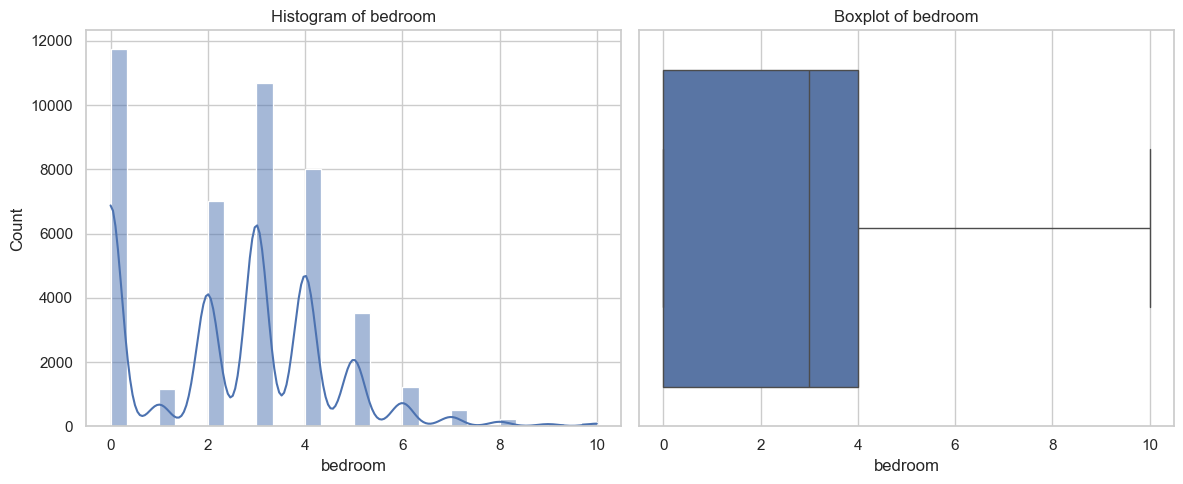

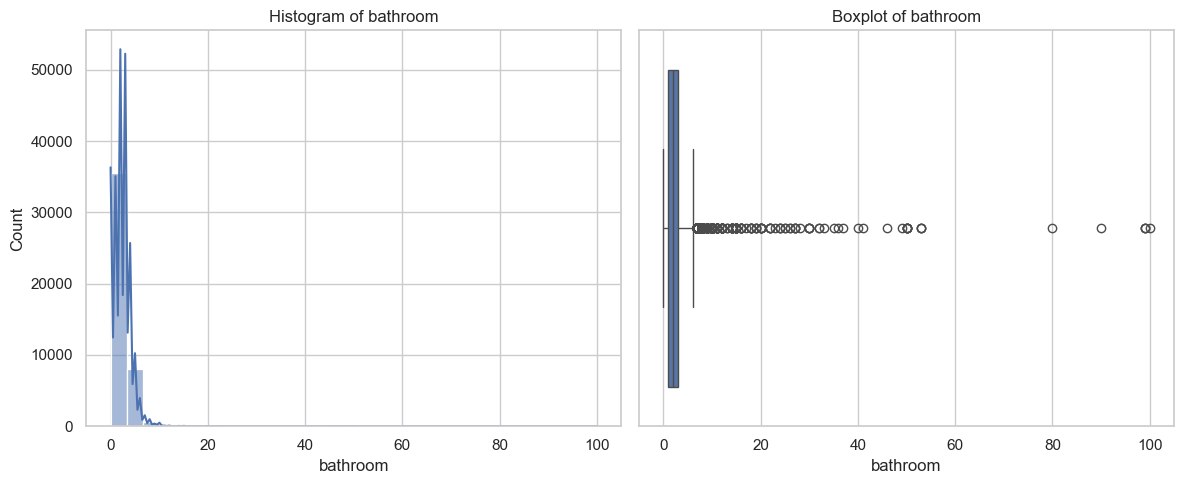

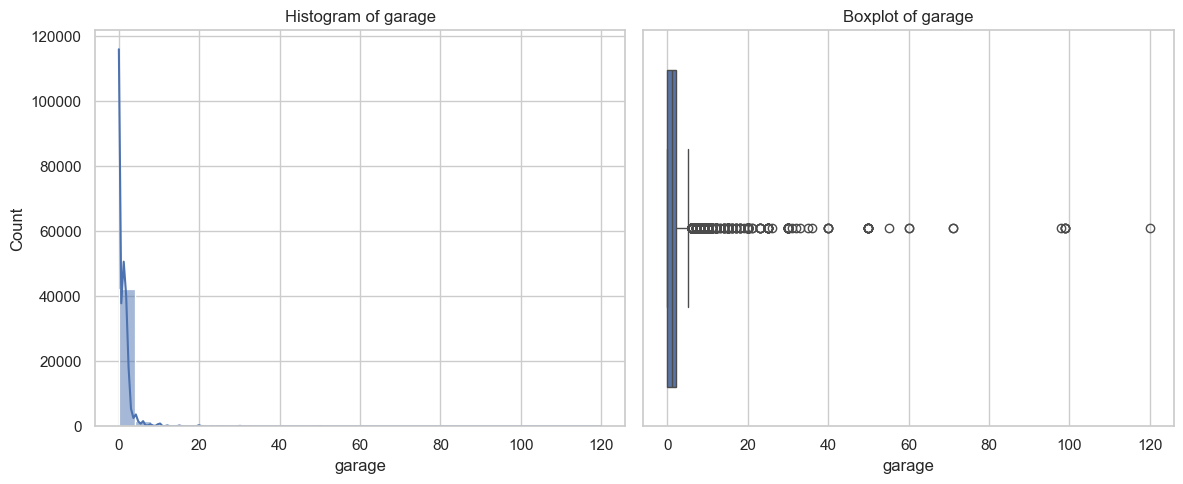

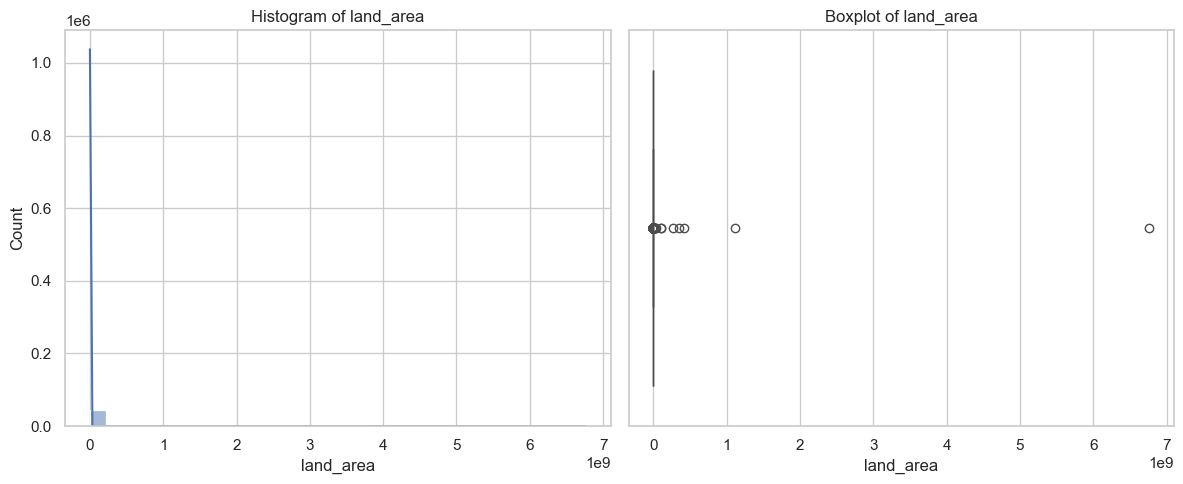

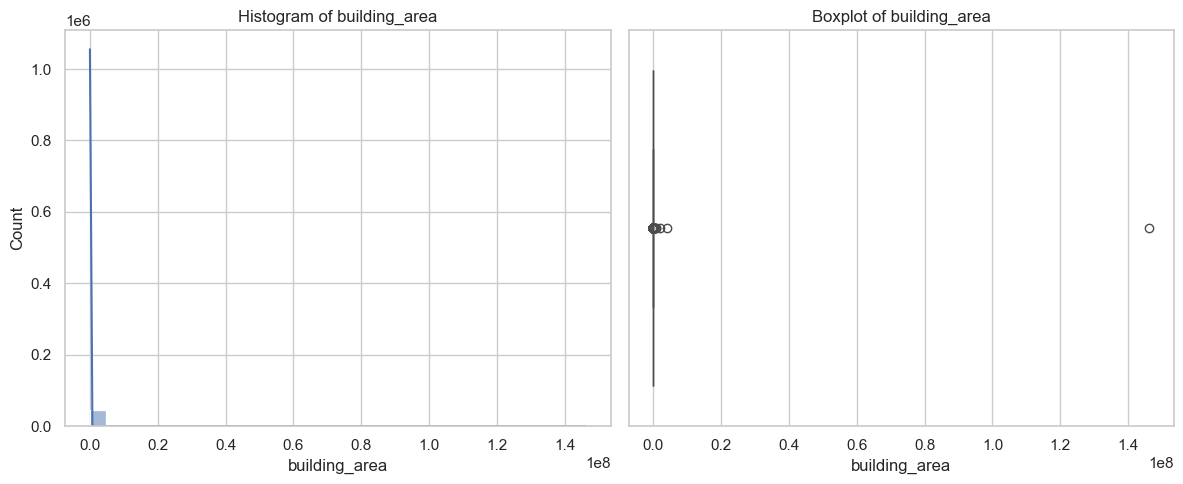

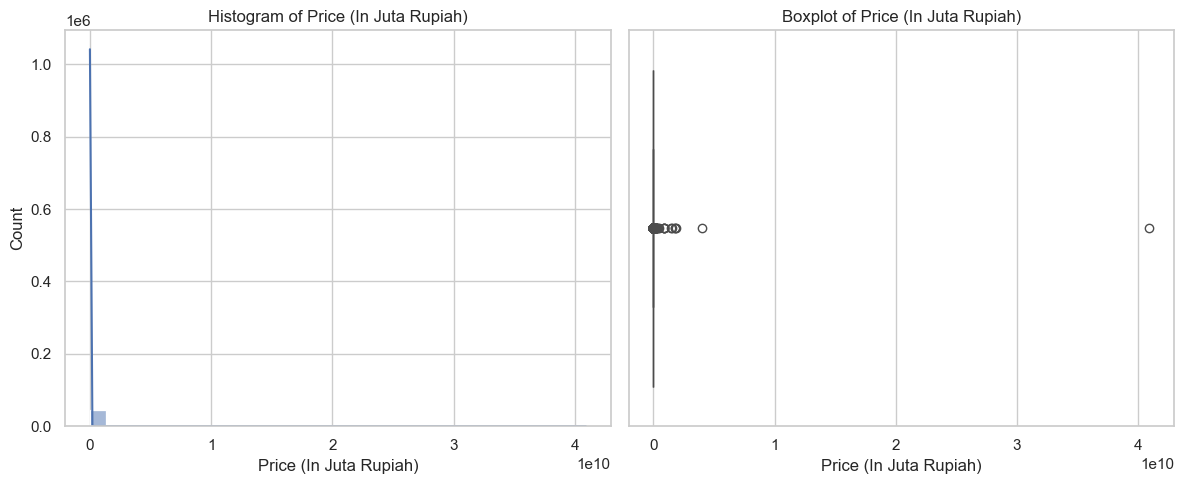

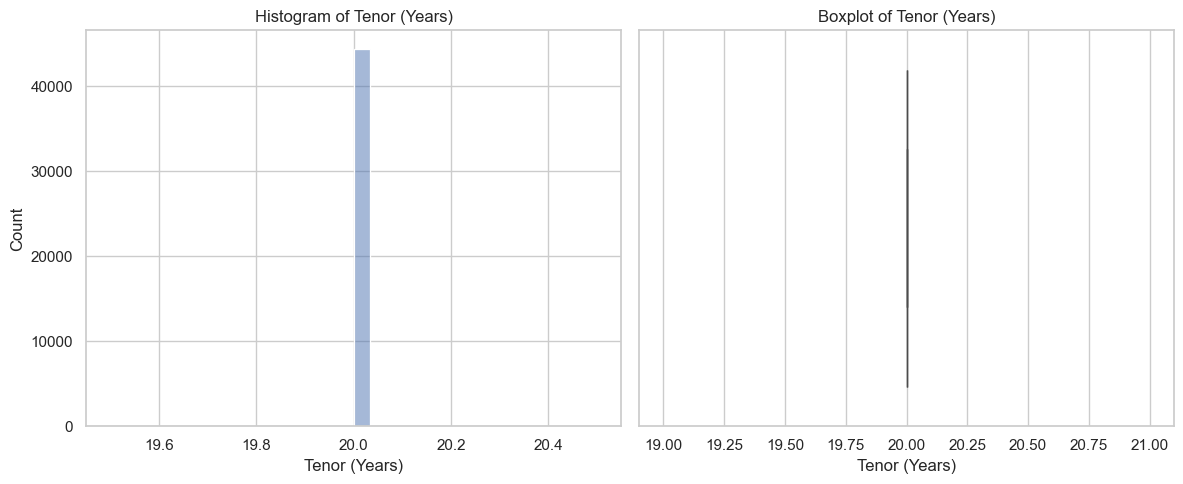

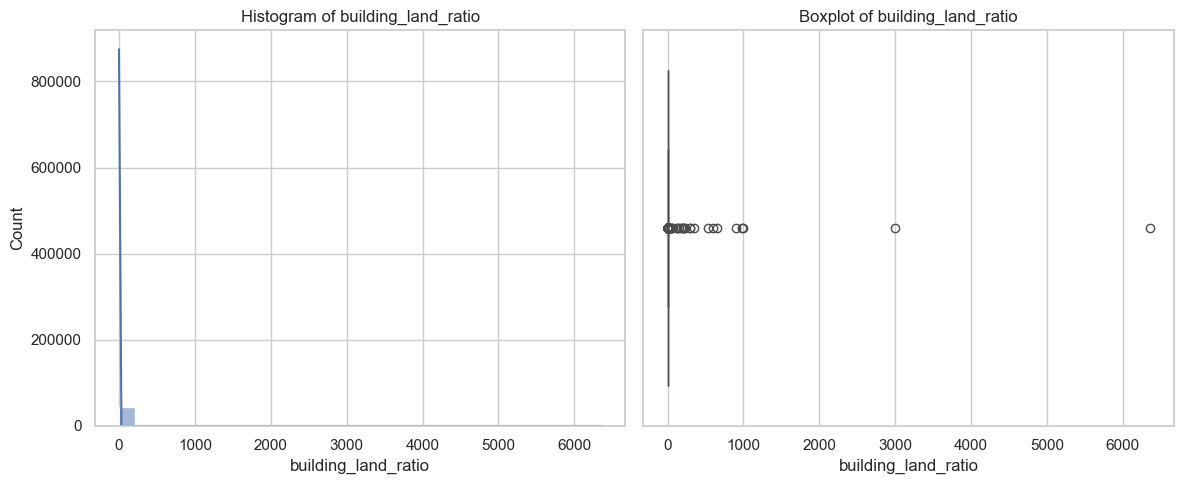

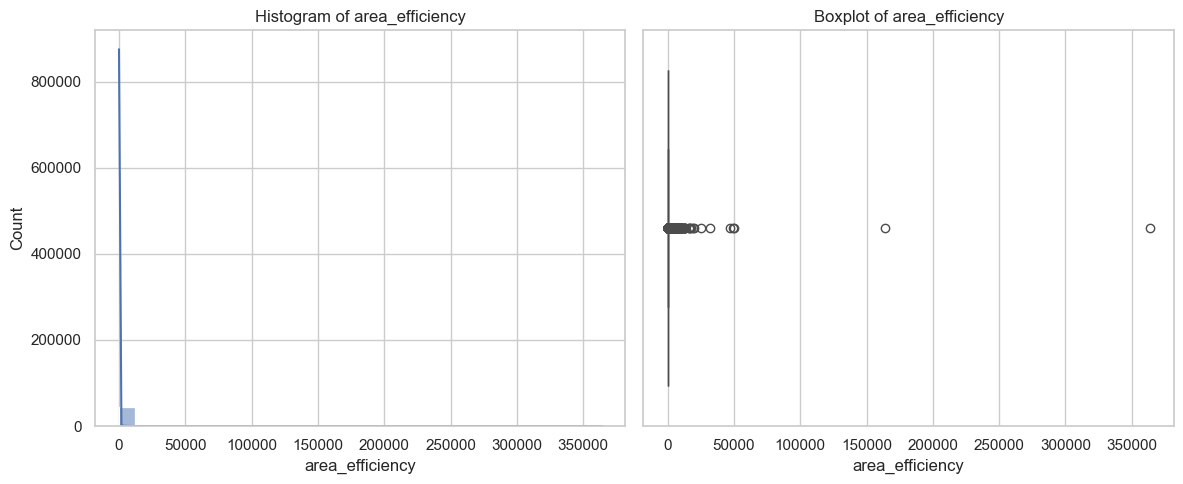

In [109]:
# Define numeric columns based on your dataset
numeric_cols = [
    'bedroom',
    'bathroom',
    'garage',
    'land_area',
    'building_area',
    'Price (In Juta Rupiah)',
    'Tenor (Years)',
    'building_land_ratio',
    'area_efficiency'
]

# Replace infinite values with NaN
df_clean = combined_df.replace([np.inf, -np.inf], np.nan)

# Create histograms and boxplots for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(12, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_clean[col].dropna(), kde=True, bins=30)
    plt.title(f'Histogram of {col}')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean[col].dropna())
    plt.title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()

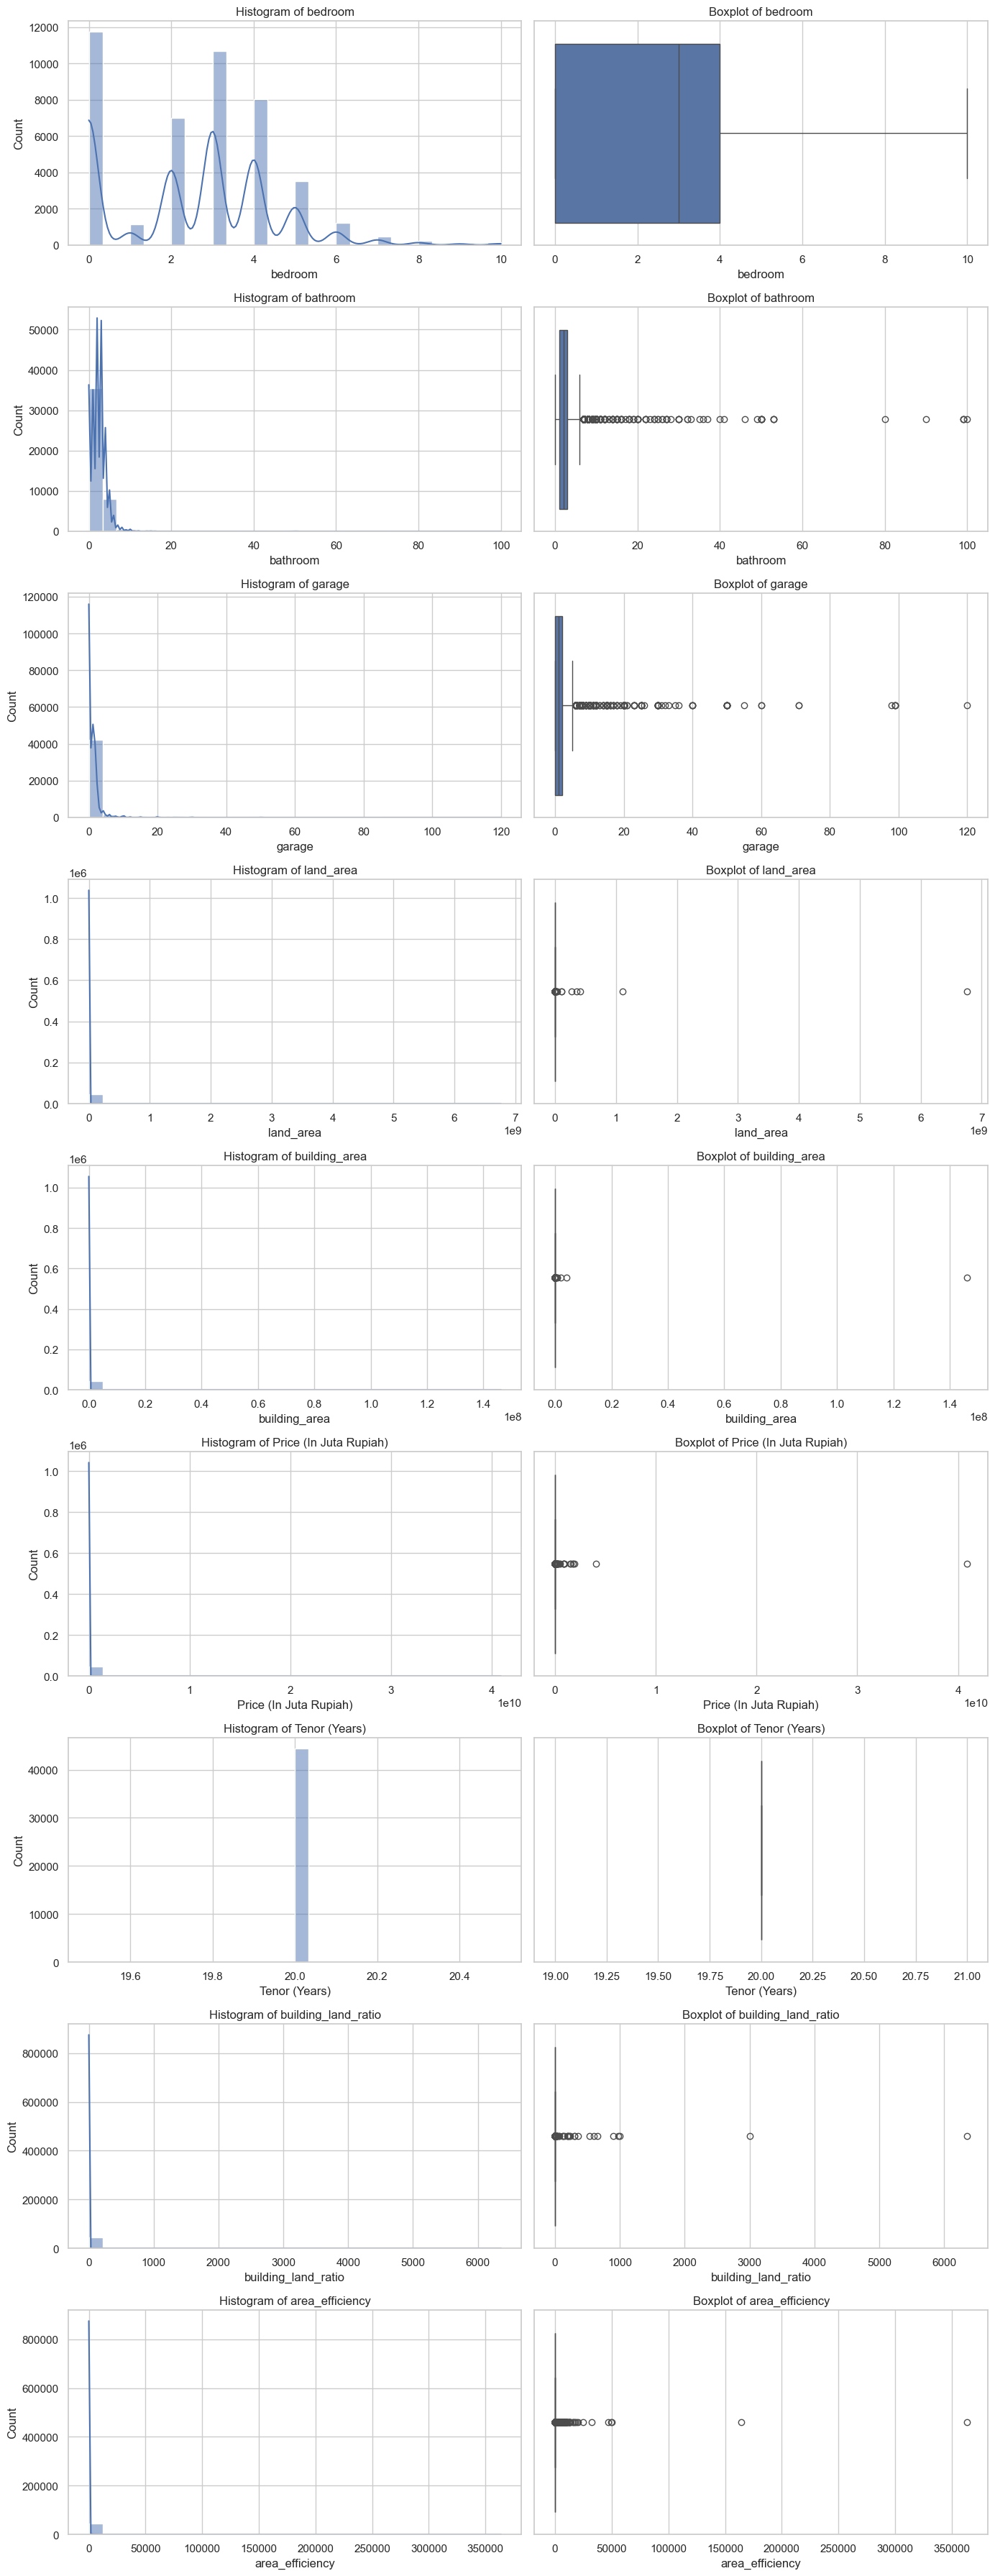

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define numeric columns based on your dataset
numeric_cols = [
    'bedroom',
    'bathroom',
    'garage',
    'land_area',
    'building_area',
    'Price (In Juta Rupiah)',
    'Tenor (Years)',
    'building_land_ratio',
    'area_efficiency'
]

# Replace infinite values with NaN
df_clean = combined_df.replace([np.inf, -np.inf], np.nan)

# Set up the overall figure
num_cols = 2  # One for histogram, one for boxplot
num_rows = len(numeric_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 4 * num_rows))

# Flatten axes array for easier indexing if needed
for i, col in enumerate(numeric_cols):
    # Histogram
    sns.histplot(df_clean[col].dropna(), kde=True, bins=30, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {col}')

    # Boxplot
    sns.boxplot(x=df_clean[col].dropna(), ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


As we can see there are some outliers, and 

Therefore we will be doing Outlier Handling

### Outlier Handling

In [28]:
# List of numeric columns you want to clean
numeric_cols = [
    'bedroom',
    'bathroom',
    'garage',
    'land_area',
    'building_area',
    'Price (In Juta Rupiah)',
    'Tenor (Years)',
    'building_land_ratio',
    'area_efficiency'
]

# Make a copy of the dataframe to preserve the original
df_no_outliers = df_clean.copy()

# Replace infinite values with NaN
df_no_outliers = df_no_outliers.replace([np.inf, -np.inf], np.nan)

# IQR-based outlier removal
for col in numeric_cols:
    Q1 = df_no_outliers[col].quantile(0.25)
    Q3 = df_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter rows
    df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]


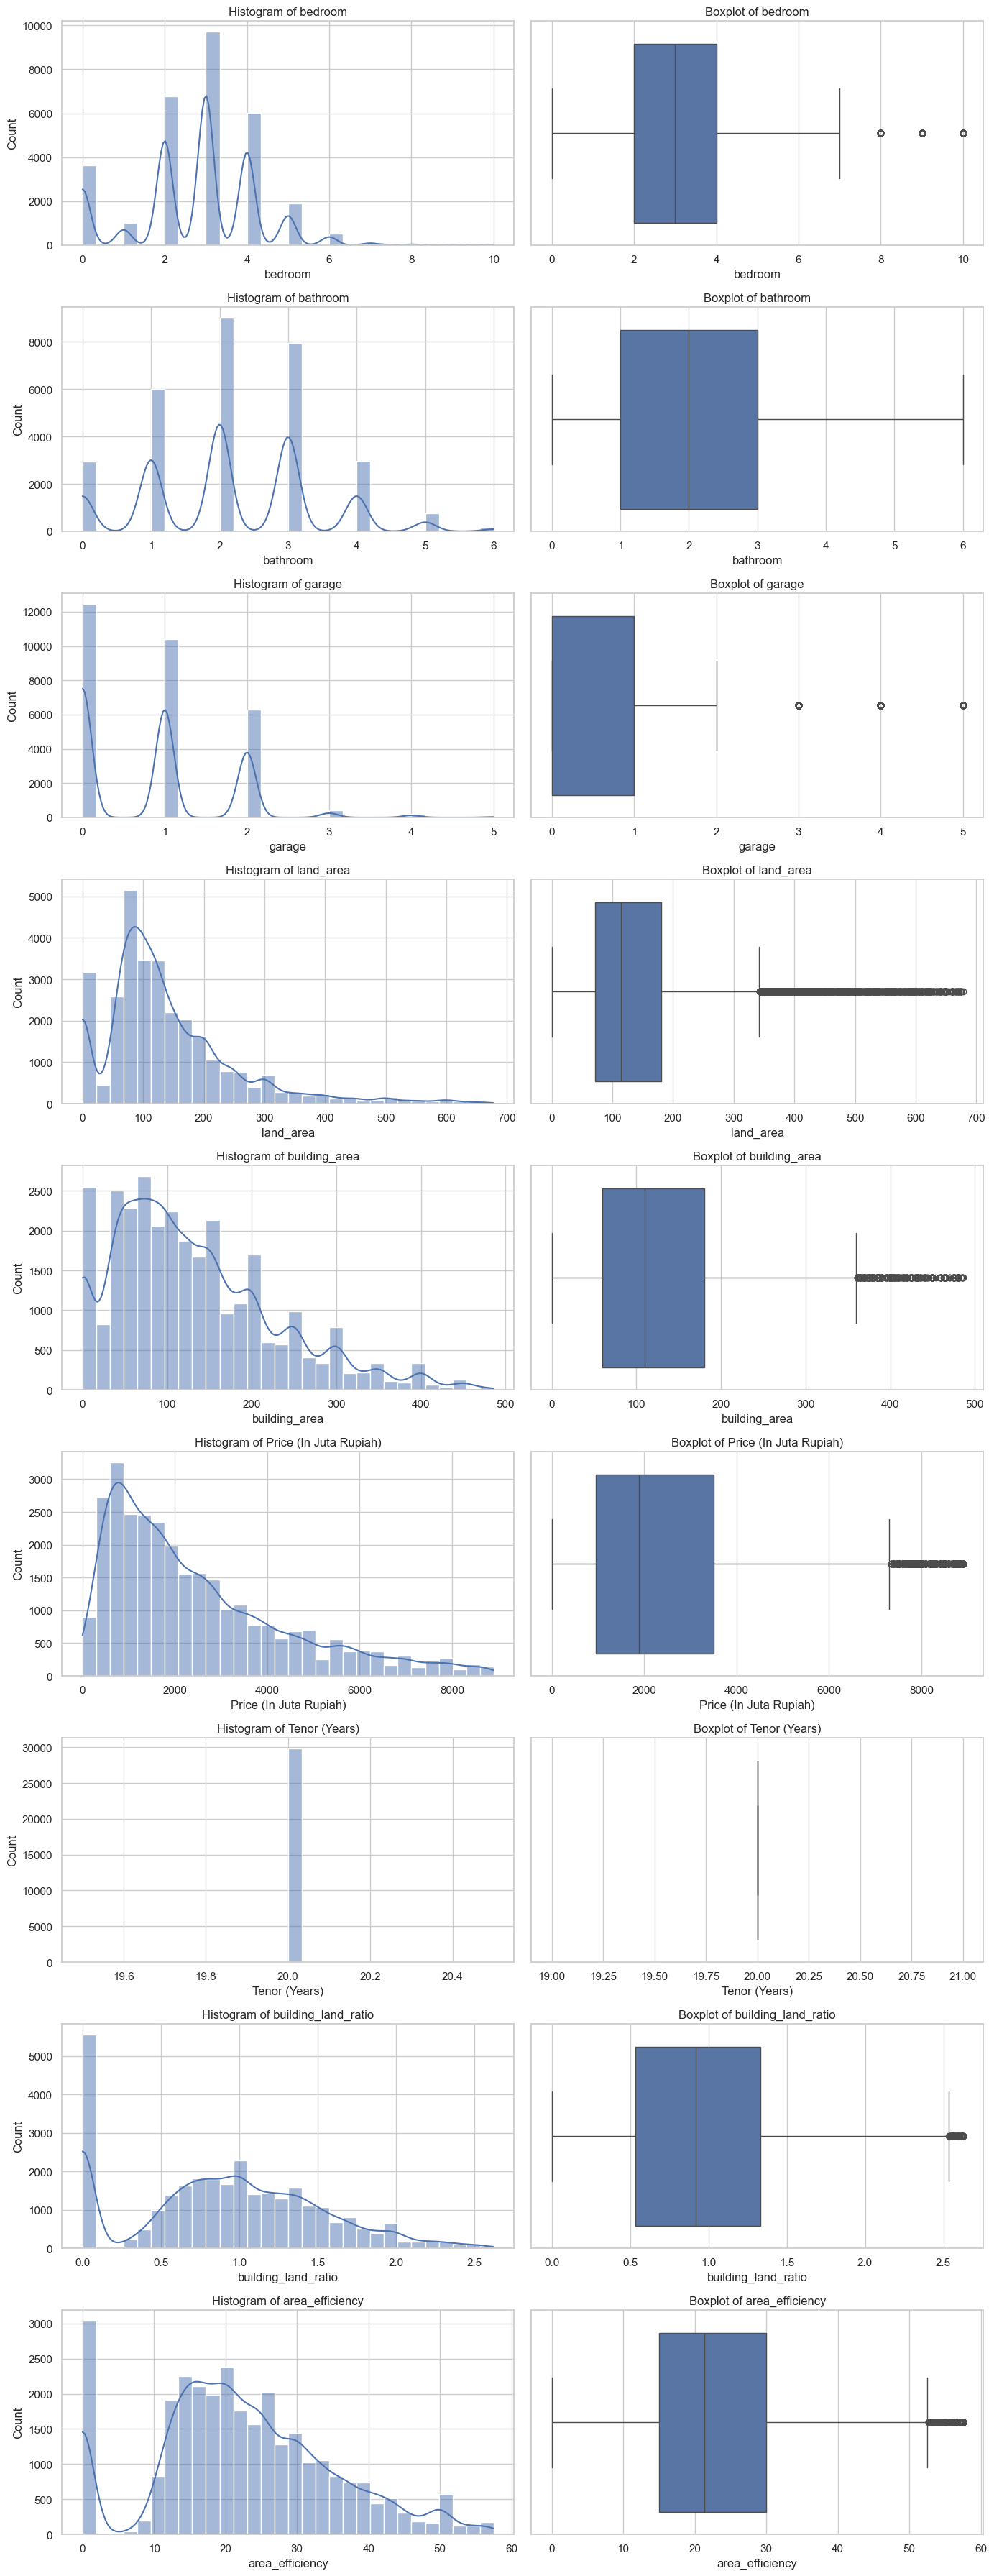

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define numeric columns based on your dataset
numeric_cols = [
    'bedroom',
    'bathroom',
    'garage',
    'land_area',
    'building_area',
    'Price (In Juta Rupiah)',
    'Tenor (Years)',
    'building_land_ratio',
    'area_efficiency'
]

# Replace infinite values with NaN
df_clean = df_no_outliers.replace([np.inf, -np.inf], np.nan)

# Set up the overall figure
num_cols = 2  # One for histogram, one for boxplot
num_rows = len(numeric_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 4 * num_rows))

# Flatten axes array for easier indexing if needed
for i, col in enumerate(numeric_cols):
    # Histogram
    sns.histplot(df_clean[col].dropna(), kde=True, bins=30, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {col}')

    # Boxplot
    sns.boxplot(x=df_clean[col].dropna(), ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


### Top Value per Categories

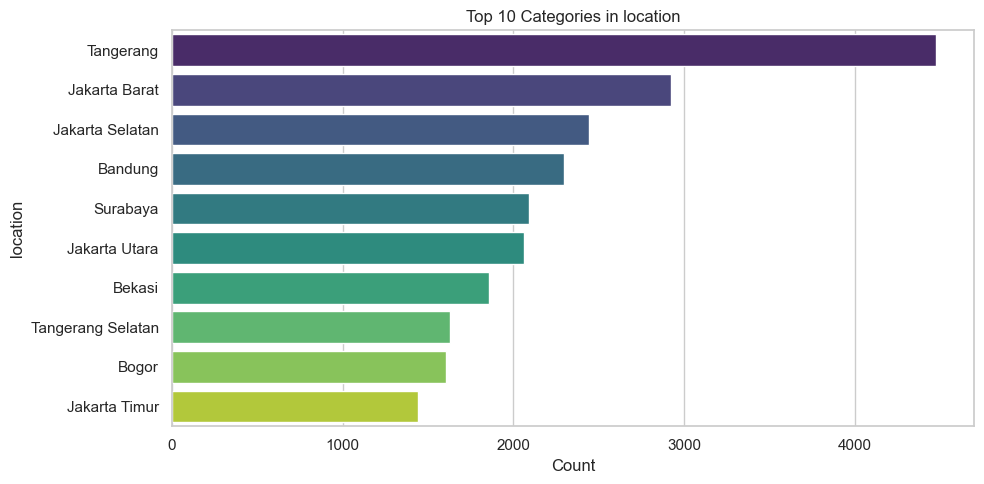

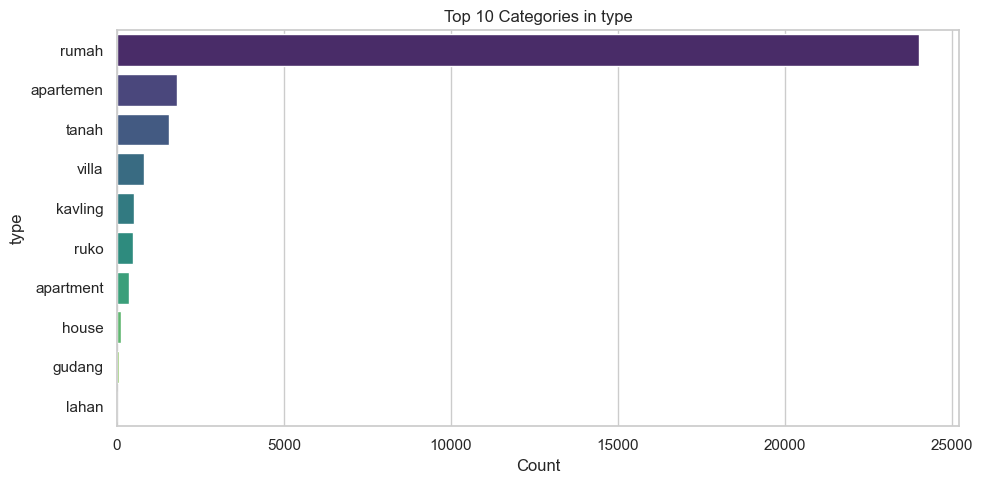

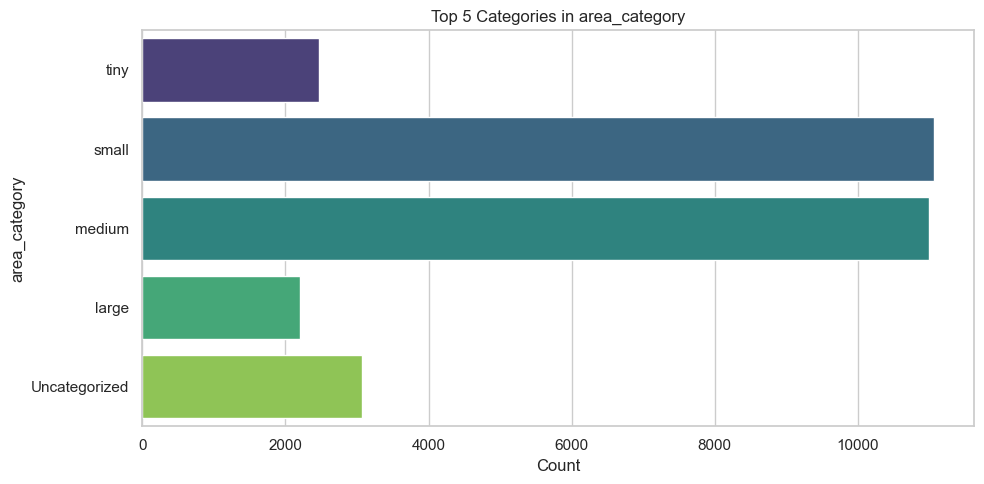

In [30]:
# List of categorical columns to analyze from your dataset
categorical_cols = [           
    'location',
    'type',
    'area_category'
]

# Set a consistent style
sns.set(style="whitegrid")

# Plot bar plots for each categorical column
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    top_categories = df_no_outliers[col].value_counts().head(10)  # top 10 for readability

    sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")
    plt.title(f"Top {len(top_categories)} Categories in {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


### Price by Category

In [31]:
df_no_outliers.head()

price                    installment  \
0  Rp 4,9 Juta Total  Rp 30 Ribuan (Tenor 20 Tahun)   
1  Rp 676 Juta Total   Rp 3 Jutaan (Tenor 20 Tahun)   
2      Rp 4,5 Miliar  Rp 23 Jutaan (Tenor 20 Tahun)   
3      Rp 2,1 Miliar  Rp 10 Jutaan (Tenor 20 Tahun)   
4      Rp 1,9 Miliar   Rp 9 Jutaan (Tenor 20 Tahun)   

                                               title           location  \
0   MURAH! Tanah Jogja Area Jakal 5 Menit Kampus UII             Sleman   
1  Tanah Murah Jogja Dekat Exit Tol Trihanggo dan...             Sleman   
2  Rumah Hotsale Dijual Cepat di Sektor 3A Bintar...  Tangerang Selatan   
3  Rumah Baru Luas 2 Lantai Dijual di Bogor View ...              Bogor   
4  Dijual Rumah PIK 2, ukuran 4x15, 2 kamar, Siap...      Jakarta Utara   

   bedroom  bathroom  garage  land_area  building_area  \
0        0       0.0     0.0      211.0            0.0   
1        0       0.0     0.0      130.0            0.0   
2        6       5.0     2.0      214.0          250.0   
3        3       2.0     1.0      120.0           93.0   
4        2       2.0     1.0       60.0           96.0   

   Price (In Juta Rupiah)   type  Tenor (Years)  is_luxury area_category  \
0                     4.9  tanah             20          0        medium   
1                   676.0  tanah             20          0        medium   
2                  4500.0  rumah             20          0        medium   
3                  2100.0  rumah             20          0         small   
4                  1900.0  rumah             20          0          tiny   

   building_land_ratio  area_efficiency  
0             0.000000         0.000000  
1             0.000000         0.000000  
2             1.168224        22.727273  
3             0.775000        18.600000  
4             1.600000        24.000000

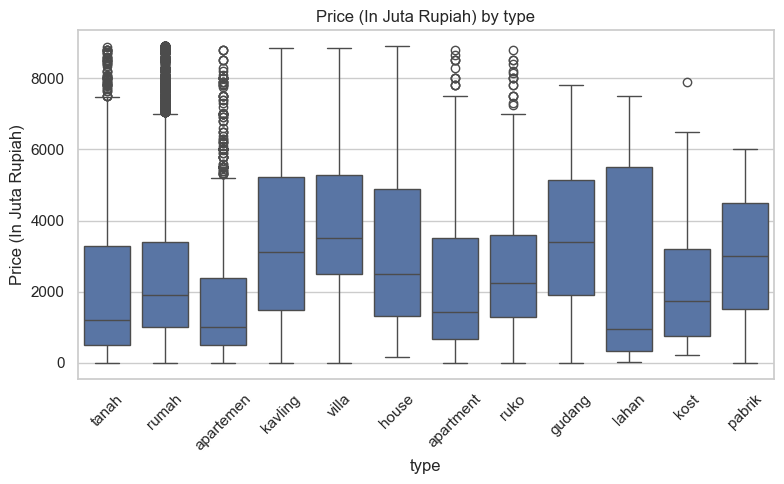

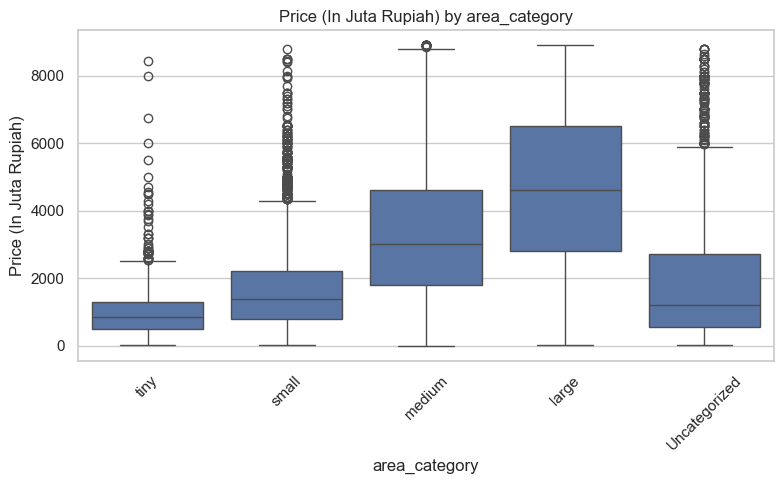

In [32]:
categorical_cols = [           
    'type',
    'area_category'
]

# Set seaborn style
sns.set(style="whitegrid")

# Create boxplots of price grouped by each category
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=col, y='Price (In Juta Rupiah)', data=df_no_outliers)
    plt.title(f'Price (In Juta Rupiah) by {col}')
    plt.ylabel('Price (In Juta Rupiah)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

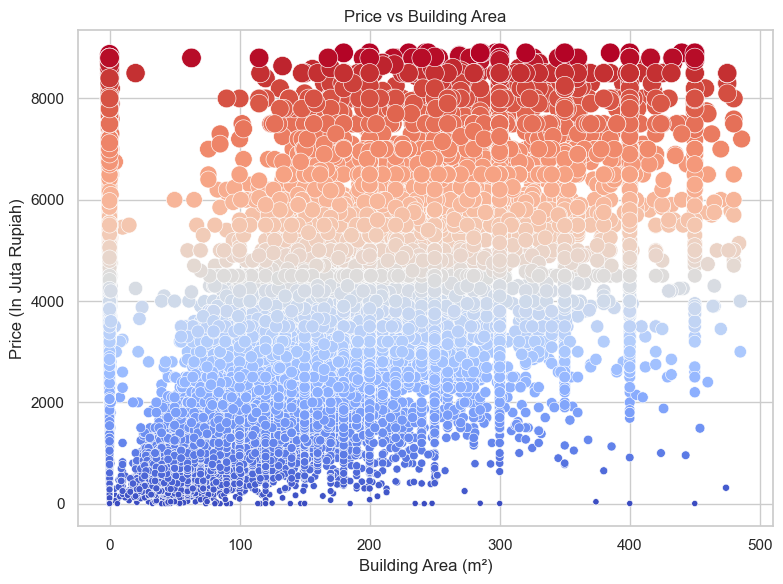

In [33]:
plt.figure(figsize=(8, 6))

# Use the 'coolwarm' or 'RdYlBu_r' palette for a blue-to-red gradient
sns.scatterplot(
    x='building_area', 
    y='Price (In Juta Rupiah)', 
    data=df_no_outliers, 
    hue='Price (In Juta Rupiah)', 
    palette='coolwarm',  # Try 'coolwarm', 'RdYlBu_r', or 'RdBu_r'
    size='Price (In Juta Rupiah)', 
    sizes=(20, 200), 
    legend=False
)

plt.title('Price vs Building Area')
plt.xlabel('Building Area (m²)')
plt.ylabel('Price (In Juta Rupiah)')
plt.tight_layout()
plt.show()


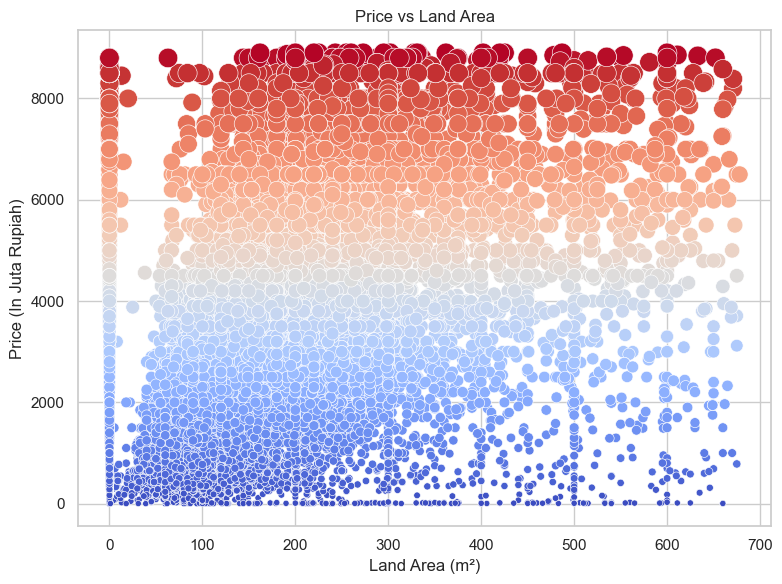

In [34]:
plt.figure(figsize=(8, 6))

# Use the 'coolwarm' or 'RdYlBu_r' palette for a blue-to-red gradient
sns.scatterplot(
    x='land_area', 
    y='Price (In Juta Rupiah)', 
    data=df_no_outliers, 
    hue='Price (In Juta Rupiah)', 
    palette='coolwarm',  # Try 'coolwarm', 'RdYlBu_r', or 'RdBu_r'
    size='Price (In Juta Rupiah)', 
    sizes=(20, 200), 
    legend=False
)

plt.title('Price vs Land Area')
plt.xlabel('Land Area (m²)')
plt.ylabel('Price (In Juta Rupiah)')
plt.tight_layout()
plt.show()


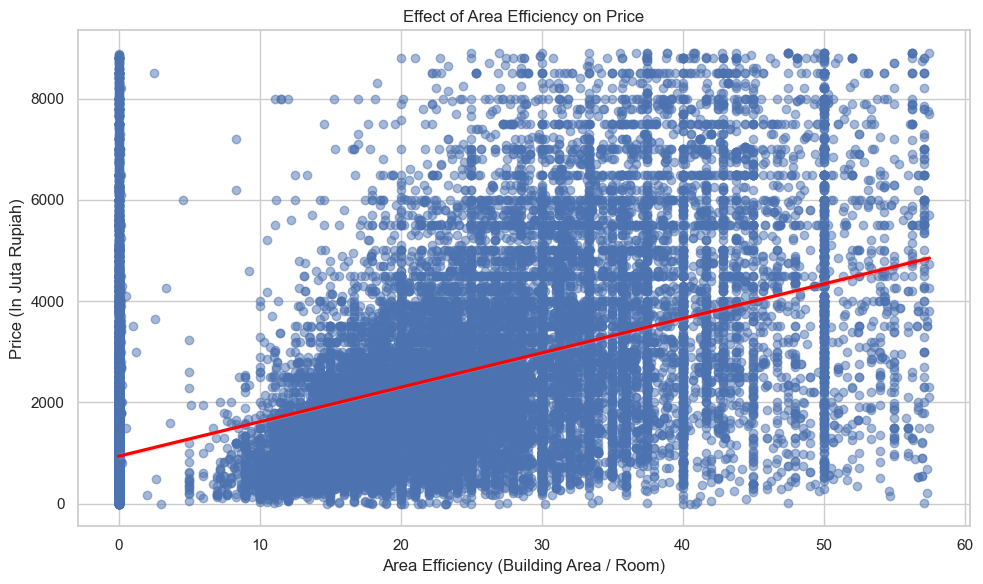

In [35]:
df_eff = df_no_outliers.replace([np.inf, -np.inf], np.nan).dropna(subset=['area_efficiency'])

# Plot: Scatter with regression line
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_eff,
    x='area_efficiency',
    y='Price (In Juta Rupiah)',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)
plt.title('Effect of Area Efficiency on Price')
plt.xlabel('Area Efficiency (Building Area / Room)')
plt.ylabel('Price (In Juta Rupiah)')
plt.tight_layout()
plt.show()

In [36]:
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29813 entries, 0 to 49998
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   price                   29813 non-null  object  
 1   installment             29813 non-null  object  
 2   title                   29811 non-null  object  
 3   location                29813 non-null  object  
 4   bedroom                 29813 non-null  Int64   
 5   bathroom                29813 non-null  float64 
 6   garage                  29813 non-null  float64 
 7   land_area               29813 non-null  float64 
 8   building_area           29813 non-null  float64 
 9   Price (In Juta Rupiah)  29813 non-null  float64 
 10  type                    29813 non-null  object  
 11  Tenor (Years)           29813 non-null  int64   
 12  is_luxury               29813 non-null  int64   
 13  area_category           29813 non-null  category
 14  building_land_ratio     298

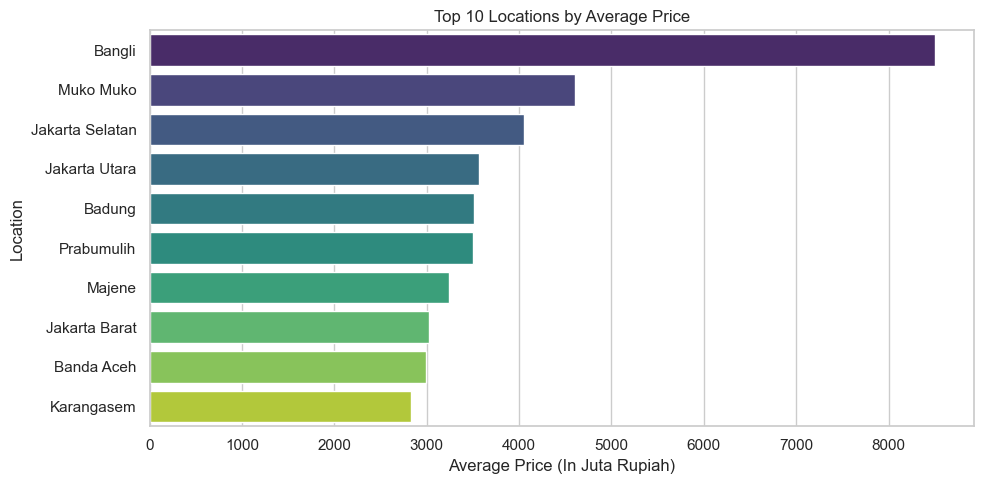

In [37]:
plt.figure(figsize=(10, 5))

# Compute top 10 locations by average price
city_avg = df_no_outliers.groupby('location')['Price (In Juta Rupiah)'].mean().sort_values(ascending=False).head(10)

# Plot
sns.barplot(x=city_avg.values, y=city_avg.index, palette="viridis")
plt.title("Top 10 Locations by Average Price")
plt.xlabel("Average Price (In Juta Rupiah)")
plt.ylabel("Location")
plt.tight_layout()
plt.show()


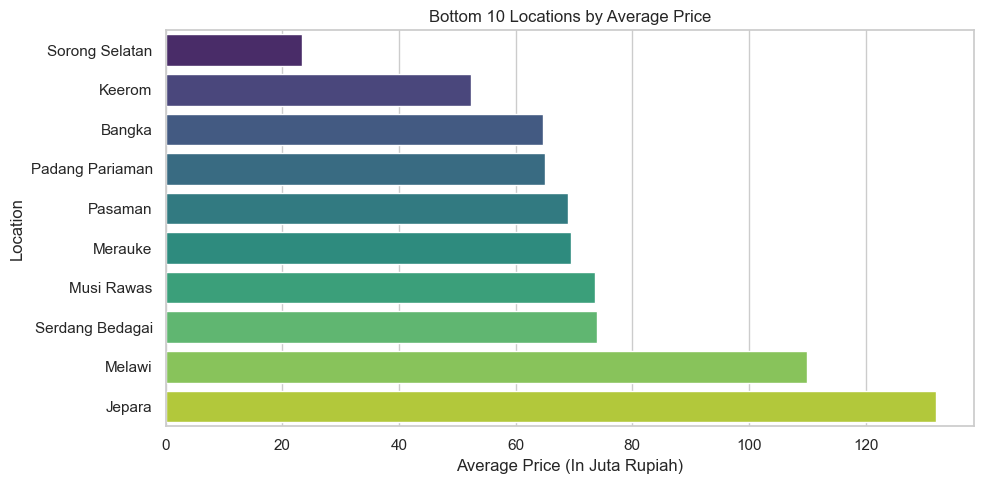

In [38]:
plt.figure(figsize=(10, 5))

# Compute bottom 10 locations by average price
city_avg = df_no_outliers.groupby('location')['Price (In Juta Rupiah)'].mean().sort_values(ascending=True).head(10)

# Plot
sns.barplot(x=city_avg.values, y=city_avg.index, palette="viridis")
plt.title("Bottom 10 Locations by Average Price")
plt.xlabel("Average Price (In Juta Rupiah)")
plt.ylabel("Location")
plt.tight_layout()
plt.show()


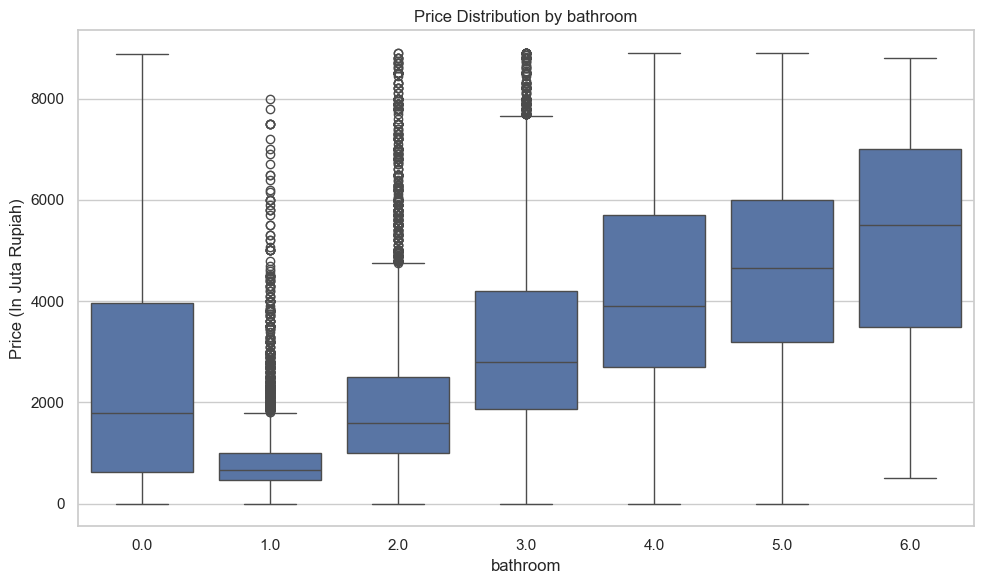

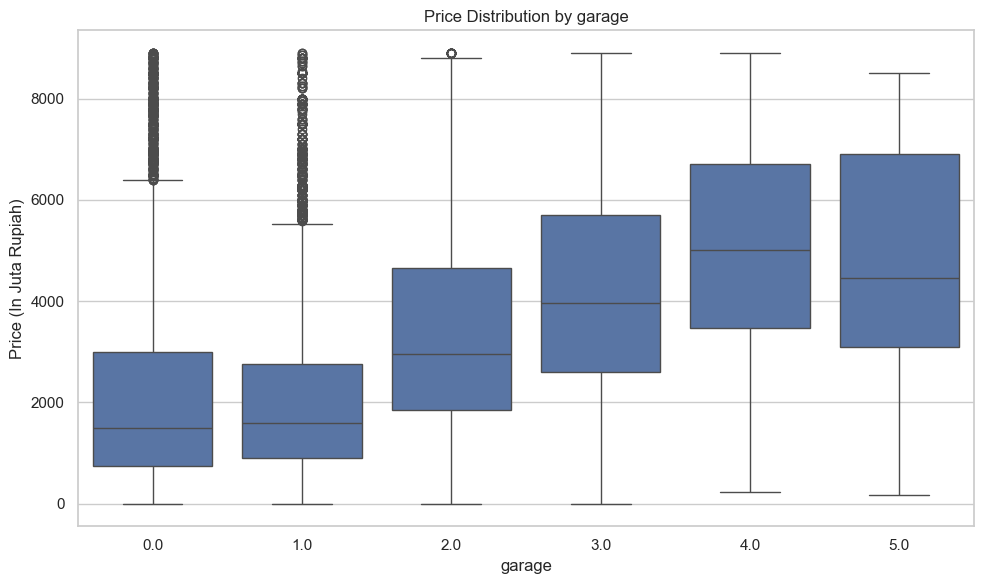

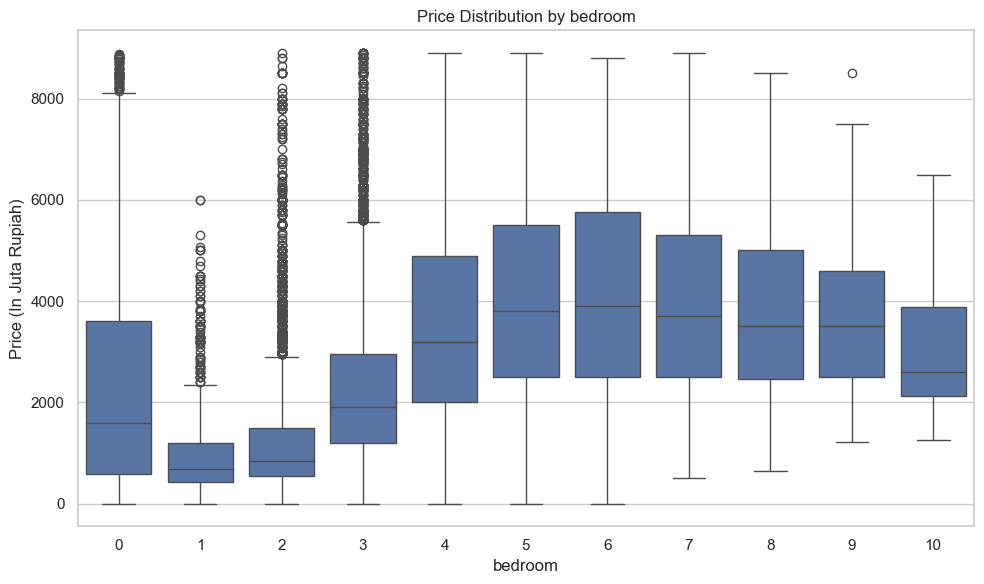

In [39]:
# List of numerical columns to compare with price
numerical_cols = ['bathroom', 'garage', 'bedroom']

# Set seaborn style
sns.set(style="whitegrid")
# Box Plots for distribution of price by numerical bins
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_no_outliers[col], y=df_no_outliers['Price (In Juta Rupiah)'])
    plt.title(f"Price Distribution by {col}")
    plt.xlabel(col)
    plt.ylabel('Price (In Juta Rupiah)')
    plt.tight_layout()
    plt.show()


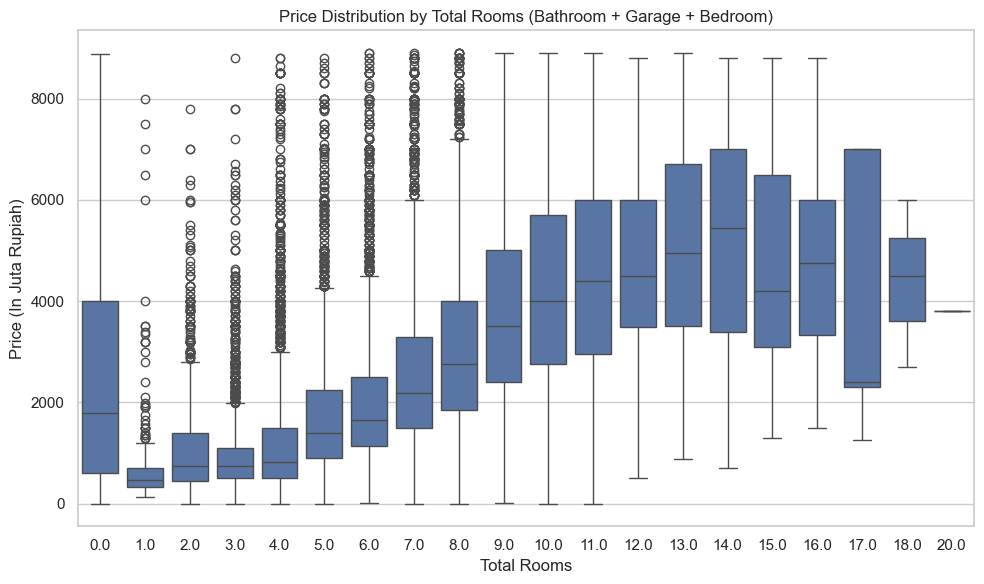

In [40]:
# Create a new column that sums up bathroom, garage, and bedroom
df_no_outliers['Total_rooms'] = df_no_outliers['bathroom'] + df_no_outliers['garage'] + df_no_outliers['bedroom']

# Plot the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_no_outliers['Total_rooms'], y=df_no_outliers['Price (In Juta Rupiah)'])
plt.title("Price Distribution by Total Rooms (Bathroom + Garage + Bedroom)")
plt.xlabel("Total Rooms")
plt.ylabel("Price (In Juta Rupiah)")
plt.tight_layout()
plt.show()


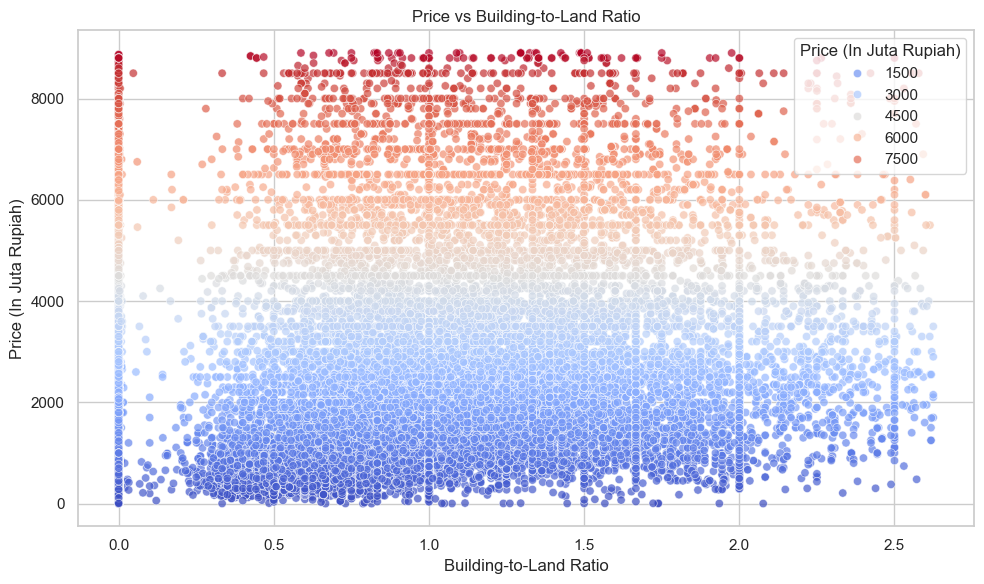

In [41]:

# Optional: remove infinite or NaN values caused by division
df_ratio = df_no_outliers.replace([np.inf, -np.inf], np.nan).dropna(subset=['building_land_ratio'])

# Plot scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_ratio,
    x='building_land_ratio',
    hue='Price (In Juta Rupiah)', 
    y='Price (In Juta Rupiah)',
    palette='coolwarm',
    alpha=0.7
)
plt.title('Price vs Building-to-Land Ratio')
plt.xlabel('Building-to-Land Ratio')
plt.ylabel('Price (In Juta Rupiah)')
plt.tight_layout()
plt.show()


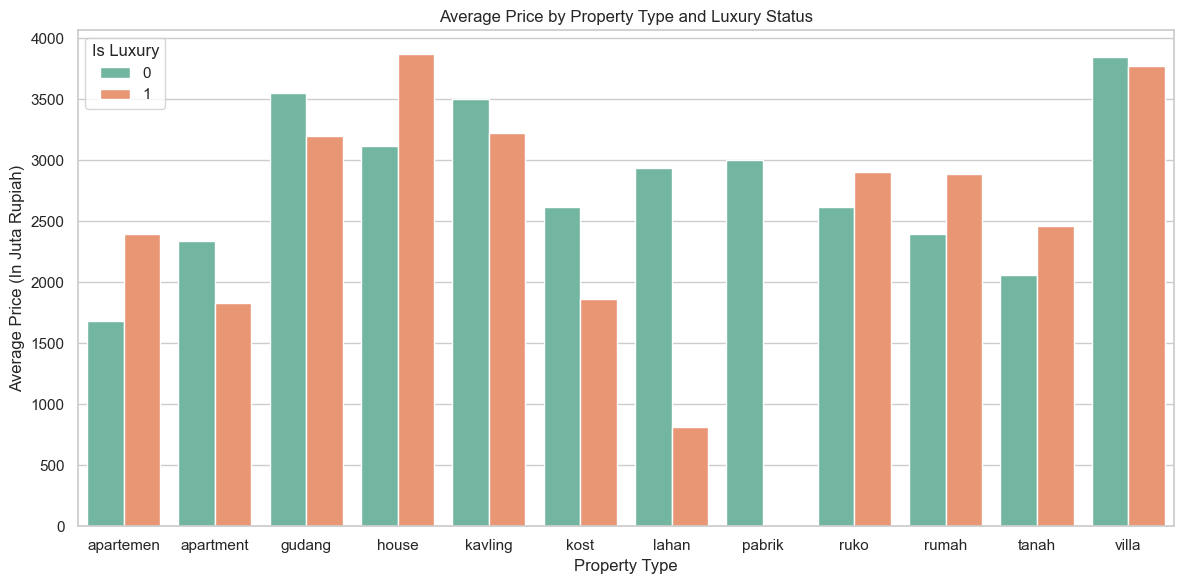

In [42]:
# Group and calculate average price
grouped_price = df_no_outliers.groupby(['type', 'is_luxury'])['Price (In Juta Rupiah)'].mean().reset_index()

# Set seaborn style
sns.set(style="whitegrid")

# Create barplot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped_price,
    x='type',
    y='Price (In Juta Rupiah)',
    hue='is_luxury',
    palette='Set2'
)
# Add title and labels
plt.title('Average Price by Property Type and Luxury Status')
plt.xlabel('Property Type')
plt.ylabel('Average Price (In Juta Rupiah)')
plt.legend(title='Is Luxury')
plt.tight_layout()
plt.show()

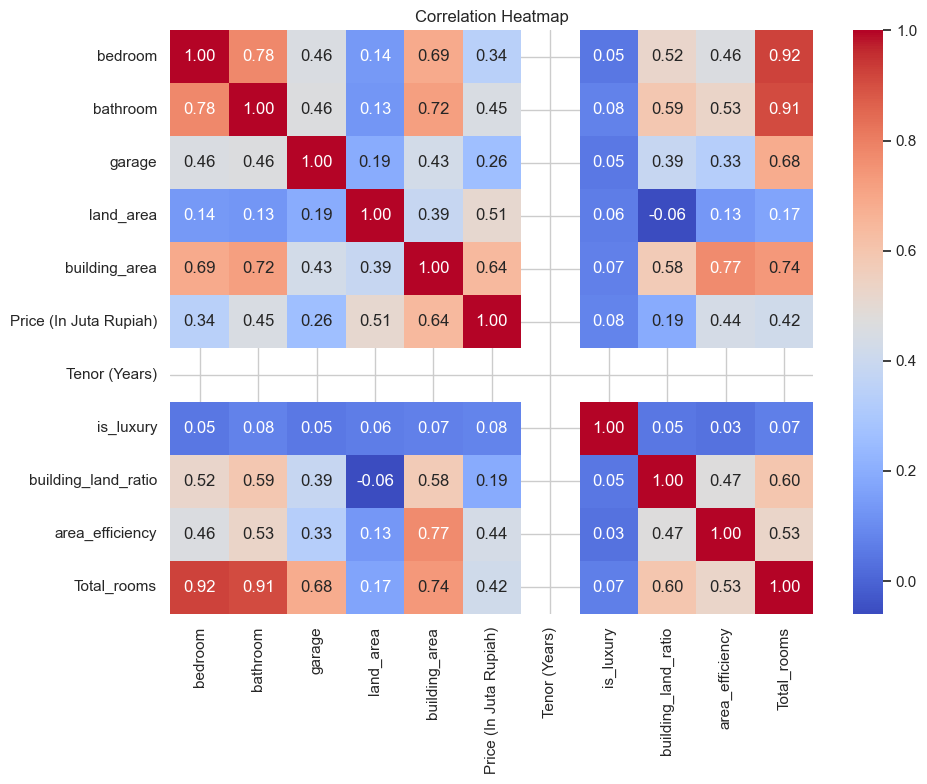

In [43]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_no_outliers.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


# Splitting

In [44]:
df_no_outliers.head()

price                    installment  \
0  Rp 4,9 Juta Total  Rp 30 Ribuan (Tenor 20 Tahun)   
1  Rp 676 Juta Total   Rp 3 Jutaan (Tenor 20 Tahun)   
2      Rp 4,5 Miliar  Rp 23 Jutaan (Tenor 20 Tahun)   
3      Rp 2,1 Miliar  Rp 10 Jutaan (Tenor 20 Tahun)   
4      Rp 1,9 Miliar   Rp 9 Jutaan (Tenor 20 Tahun)   

                                               title           location  \
0   MURAH! Tanah Jogja Area Jakal 5 Menit Kampus UII             Sleman   
1  Tanah Murah Jogja Dekat Exit Tol Trihanggo dan...             Sleman   
2  Rumah Hotsale Dijual Cepat di Sektor 3A Bintar...  Tangerang Selatan   
3  Rumah Baru Luas 2 Lantai Dijual di Bogor View ...              Bogor   
4  Dijual Rumah PIK 2, ukuran 4x15, 2 kamar, Siap...      Jakarta Utara   

   bedroom  bathroom  garage  land_area  building_area  \
0        0       0.0     0.0      211.0            0.0   
1        0       0.0     0.0      130.0            0.0   
2        6       5.0     2.0      214.0          250.0   
3        3       2.0     1.0      120.0           93.0   
4        2       2.0     1.0       60.0           96.0   

   Price (In Juta Rupiah)   type  Tenor (Years)  is_luxury area_category  \
0                     4.9  tanah             20          0        medium   
1                   676.0  tanah             20          0        medium   
2                  4500.0  rumah             20          0        medium   
3                  2100.0  rumah             20          0         small   
4                  1900.0  rumah             20          0          tiny   

   building_land_ratio  area_efficiency  Total_rooms  
0             0.000000         0.000000          0.0  
1             0.000000         0.000000          0.0  
2             1.168224        22.727273         13.0  
3             0.775000        18.600000          6.0  
4             1.600000        24.000000          5.0

In [45]:
# Drop NaN values from both X and y simultaneously
df_ready = df_no_outliers.dropna(subset=['Price (In Juta Rupiah)'])  # Drop rows with NaN in the target column
X = df_ready.drop(['Price (In Juta Rupiah)'], axis=1)         # Drop the 'Price' column from the dataset to get features
y = df_ready['Price (In Juta Rupiah)']                        # Extract 'Price' as the target variable

# Now, X and y should have the same number of samples
print(X.shape)
print(y.shape)


(29813, 16)
(29813,)


In [46]:
from sklearn.model_selection import train_test_split
# First, split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Multicollinearity Study & Feature Selection

In [47]:
# Calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

In [48]:
# Coerce values to numeric (invalid parsing will be NaN)
converted = X_train.apply(pd.to_numeric, errors='coerce')

# Identify entries where coercion failed but original wasn't NaN
non_numeric_mask = converted.isna() & ~X_train.isna()

# Columns with non-numeric entries
print("Columns with non-numeric values:")
print(non_numeric_mask.any())

# Get the actual column names
problematic_cols = non_numeric_mask.any()[non_numeric_mask.any()].index

# Get the rows where any non-numeric value exists
problematic_rows = non_numeric_mask.any(axis=1)

# Display problematic cells only
print("Problematic values:")
print(X_train.loc[problematic_rows, problematic_cols])


Columns with non-numeric values:
price                   True
installment             True
title                   True
location                True
bedroom                False
bathroom               False
garage                 False
land_area              False
building_area          False
type                    True
Tenor (Years)          False
is_luxury              False
area_category           True
building_land_ratio    False
area_efficiency        False
Total_rooms            False
dtype: bool
Problematic values:
                   price                    installment  \
12166     Rp 1,36 Miliar   Rp 7 Jutaan (Tenor 20 Tahun)   
35457     Rp 2,25 Miliar  Rp 11 Jutaan (Tenor 20 Tahun)   
10671     Rp 2,45 Miliar  Rp 12 Jutaan (Tenor 20 Tahun)   
45701        Rp 6 Miliar  Rp 30 Jutaan (Tenor 20 Tahun)   
23498      Rp 3,8 Miliar  Rp 19 Jutaan (Tenor 20 Tahun)   
...                  ...                            ...   
49979    Rp 6,8 Juta /m²  Rp 40 Ribuan (Tenor 20 Tahun)   

In [49]:
# Step 1: Try to convert all columns to numeric
X_train_converted = X_train.apply(pd.to_numeric, errors='coerce')

# Step 2: Remove columns with any NaN or infinite values
X_train_cleaned = X_train_converted.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# Step 3: Confirm all columns are truly numeric
non_numeric_cols = X_train_cleaned.columns[~X_train_cleaned.applymap(np.isreal).all()]
if not non_numeric_cols.empty:
    print("Non-numeric columns still present:", non_numeric_cols.tolist())

# Step 4: Add constant and calculate VIF only if safe
try:
    X = add_constant(X_train_cleaned)
    vif_scores = pd.DataFrame({
        'Feature': X.columns,
        'VIF_score': [vif(X.values.astype(float), i) for i in range(X.shape[1])]
    })
    vif_scores = vif_scores[vif_scores['Feature'] != 'const']
    print(vif_scores.sort_values(by='VIF_score', ascending=False))
except Exception as e:
    print("VIF calculation failed:", e)


               Feature  VIF_score
0              bedroom        inf
1             bathroom        inf
2               garage        inf
9          Total_rooms        inf
5        Tenor (Years)  10.440954
4        building_area   6.035379
8      area_efficiency   2.821753
7  building_land_ratio   1.912732
3            land_area   1.598208
6            is_luxury   1.011325


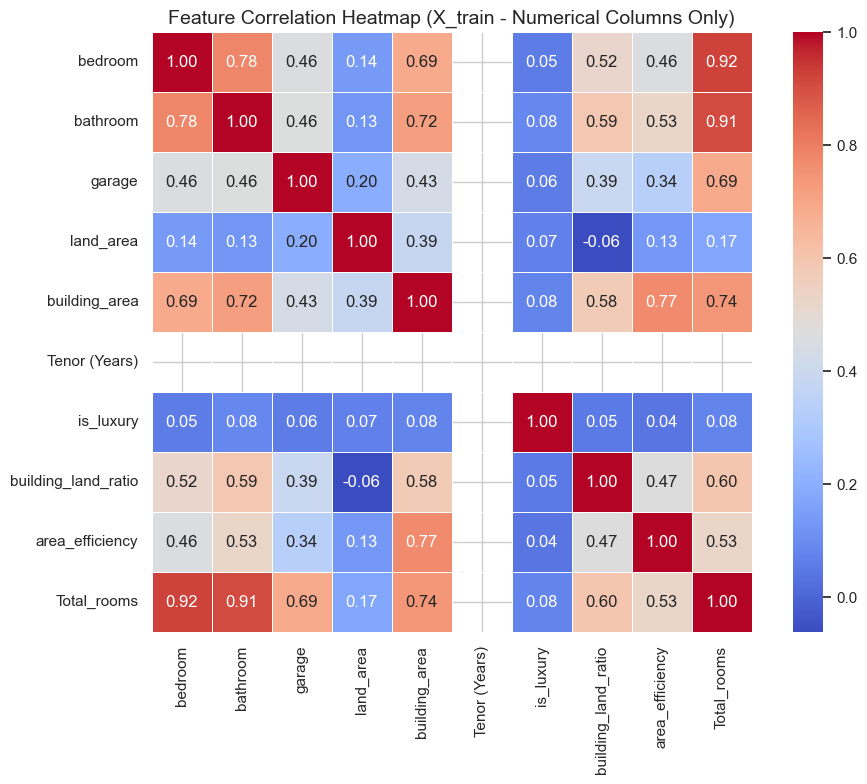

In [50]:
X_train_numeric = X_train.select_dtypes(include='number')

# Compute the correlation matrix for only numerical columns
corr_matrix = X_train_numeric.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Feature Correlation Heatmap (X_train - Numerical Columns Only)", fontsize=14)
plt.tight_layout()
plt.show()

In [115]:
X_train = X_train.drop(columns='Total_rooms')
X_test = X_test.drop(columns='Total_rooms')


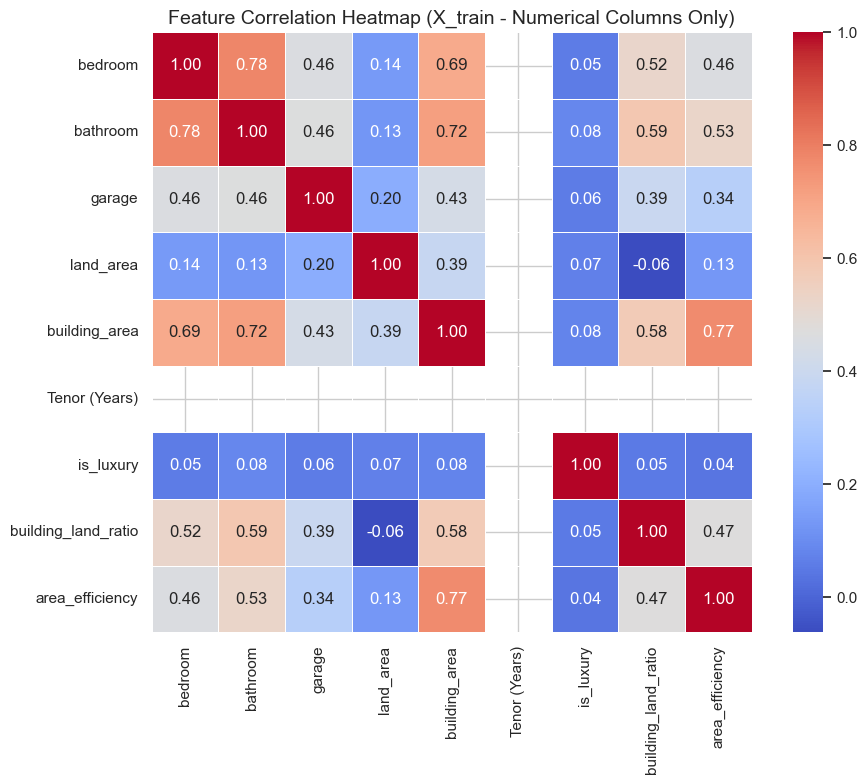

In [116]:
X_train_numeric = X_train.select_dtypes(include='number')

# Compute the correlation matrix for only numerical columns
corr_matrix = X_train_numeric.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Feature Correlation Heatmap (X_train - Numerical Columns Only)", fontsize=14)
plt.tight_layout()
plt.show()

# Encoding & Scaling

In [51]:
X_train = X_train.drop(columns=['price', 'installment', 'title']) # Drop because the Data has been Extracted into Another Col
X_test = X_test.drop(columns=['price', 'installment', 'title']) # Drop because the Data has been Extracted into Another Col
X_train.head(5)

location  bedroom  bathroom  garage  land_area  building_area  \
12166          Tangerang        3       2.0     0.0       94.0          117.0   
35457      Jakarta Barat        3       3.0     1.0       90.0          140.0   
10671  Tangerang Selatan        3       2.0     0.0      120.0          120.0   
45701             Malang       10       3.0     5.0      479.0          400.0   
23498    Jakarta Selatan        3       2.0     0.0        0.0          142.0   

        type  Tenor (Years)  is_luxury  area_category  building_land_ratio  \
12166  rumah             20          0          small             1.244681   
35457  rumah             20          0          small             1.555556   
10671  rumah             20          1          small             1.000000   
45701  rumah             20          0          large             0.835073   
23498  rumah             20          0  Uncategorized             0.000000   

       area_efficiency  Total_rooms  
12166        23.400000          5.0  
35457        23.333333          7.0  
10671        24.000000          5.0  
45701        30.769231         18.0  
23498        28.400000          5.0

In [52]:
X_test.head(5)

location  bedroom  bathroom  garage  land_area  building_area  \
9009   Jakarta Barat        3       3.0     0.0        0.0          135.0   
981    Jakarta Barat        3       3.0     0.0       90.0          130.0   
457         Denpasar        2       3.0     2.0      103.0          240.0   
24799     Yogyakarta        0       0.0     0.0      110.0            0.0   
33475      Tangerang        3       2.0     1.0       90.0           73.0   

            type  Tenor (Years)  is_luxury  area_category  \
9009   apartemen             20          0  Uncategorized   
981        rumah             20          0          small   
457        rumah             20          0          small   
24799      lahan             20          1          small   
33475      rumah             20          0          small   

       building_land_ratio  area_efficiency  Total_rooms  
9009              0.000000        22.500000          6.0  
981               1.444444        21.666667          6.0  
457               2.330097        48.000000          7.0  
24799             0.000000         0.000000          0.0  
33475             0.811111        14.600000          6.0

In [53]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23850 entries, 12166 to 38566
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   location             23850 non-null  object  
 1   bedroom              23850 non-null  Int64   
 2   bathroom             23850 non-null  float64 
 3   garage               23850 non-null  float64 
 4   land_area            23850 non-null  float64 
 5   building_area        23850 non-null  float64 
 6   type                 23850 non-null  object  
 7   Tenor (Years)        23850 non-null  int64   
 8   is_luxury            23850 non-null  int64   
 9   area_category        23850 non-null  category
 10  building_land_ratio  23850 non-null  float64 
 11  area_efficiency      23850 non-null  float64 
 12  Total_rooms          23850 non-null  Float64 
dtypes: Float64(1), Int64(1), category(1), float64(6), int64(2), object(2)
memory usage: 2.4+ MB


In [54]:
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Ensure both columns are of string type
X_train['is_luxury'] = X_train['is_luxury'].astype(str)
X_test['is_luxury'] = X_test['is_luxury'].astype(str)

# Fit the label encoder on both 'is_luxury' and 'price_category' from both training and test data
label_encoder.fit(pd.concat([X_train['is_luxury'], X_test['is_luxury']]))

# Apply label encoding to 'is_luxury' for both training and test data
X_train['is_luxury'] = label_encoder.transform(X_train['is_luxury'])
X_test['is_luxury'] = label_encoder.transform(X_test['is_luxury'])



In [55]:
# Instantiate the StandardScaler
scaler = StandardScaler()

# List of numerical features to scale
numerical_features = ['bedroom', 'bathroom', 'garage', 'land_area', 'building_area', 'Tenor (Years)']

# Apply scaling to the selected numerical features in the training set
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])

In [56]:
X_train.head()

location   bedroom  bathroom    garage  land_area  \
12166          Tangerang  0.161611 -0.132397 -0.981350  -0.411925   
35457      Jakarta Barat  0.161611  0.666003  0.176521  -0.448443   
10671  Tangerang Selatan  0.161611 -0.132397 -0.981350  -0.174558   
45701             Malang  4.865416  0.666003  4.808004   3.102936   
23498    Jakarta Selatan  0.161611 -0.132397 -0.981350  -1.270099   

       building_area   type  Tenor (Years)  is_luxury  area_category  \
12166      -0.136382  rumah            0.0          0          small   
35457       0.104632  rumah            0.0          0          small   
10671      -0.104945  rumah            0.0          1          small   
45701       2.829142  rumah            0.0          0          large   
23498       0.125590  rumah            0.0          0  Uncategorized   

       building_land_ratio  area_efficiency  Total_rooms  
12166             1.244681        23.400000          5.0  
35457             1.555556        23.333333          7.0  
10671             1.000000        24.000000          5.0  
45701             0.835073        30.769231         18.0  
23498             0.000000        28.400000          5.0

In [57]:

# Concatenate train and test data to ensure consistency in dummy variable columns
combined = pd.concat([X_train, X_test], axis=0, ignore_index=True)

# Apply get_dummies to the concatenated dataset
combined_encoded = pd.get_dummies(combined, columns=['location', 'type', 'area_category'], drop_first=True)

# Split back into train and test sets
X_train_final = combined_encoded.iloc[:len(X_train), :]
X_test_final = combined_encoded.iloc[len(X_train):, :]


In [58]:
X_train_final.head(5)

bedroom  bathroom    garage  land_area  building_area  Tenor (Years)  \
0  0.161611 -0.132397 -0.981350  -0.411925      -0.136382            0.0   
1  0.161611  0.666003  0.176521  -0.448443       0.104632            0.0   
2  0.161611 -0.132397 -0.981350  -0.174558      -0.104945            0.0   
3  4.865416  0.666003  4.808004   3.102936       2.829142            0.0   
4  0.161611 -0.132397 -0.981350  -1.270099       0.125590            0.0   

   is_luxury  building_land_ratio  area_efficiency  Total_rooms  ...  \
0          0             1.244681        23.400000          5.0  ...   
1          0             1.555556        23.333333          7.0  ...   
2          1             1.000000        24.000000          5.0  ...   
3          0             0.835073        30.769231         18.0  ...   
4          0             0.000000        28.400000          5.0  ...   

   type_lahan  type_pabrik  type_ruko  type_rumah  type_tanah  type_villa  \
0       False        False      False        True       False       False   
1       False        False      False        True       False       False   
2       False        False      False        True       False       False   
3       False        False      False        True       False       False   
4       False        False      False        True       False       False   

   area_category_small  area_category_medium  area_category_large  \
0                 True                 False                False   
1                 True                 False                False   
2                 True                 False                False   
3                False                 False                 True   
4                False                 False                False   

   area_category_Uncategorized  
0                        False  
1                        False  
2                        False  
3                        False  
4                         True  

[5 rows x 199 columns]

In [59]:
# Apply the same scaling to the test set (using the already fitted scaler)
X_test_final[numerical_features] = scaler.transform(X_test_final[numerical_features])

In [60]:
X_test_final.head()

bedroom  bathroom    garage  land_area  building_area  Tenor (Years)  \
23850  0.161611  0.666003 -0.981350  -1.270099       0.052238            0.0   
23851  0.161611  0.666003 -0.981350  -0.448443      -0.000156            0.0   
23852 -0.510361  0.666003  1.334391  -0.329759       1.152521            0.0   
23853 -1.854305 -1.729197 -0.981350  -0.265853      -1.362411            0.0   
23854  0.161611 -0.132397  0.176521  -0.448443      -0.597453            0.0   

       is_luxury  building_land_ratio  area_efficiency  Total_rooms  ...  \
23850          0             0.000000        22.500000          6.0  ...   
23851          0             1.444444        21.666667          6.0  ...   
23852          0             2.330097        48.000000          7.0  ...   
23853          1             0.000000         0.000000          0.0  ...   
23854          0             0.811111        14.600000          6.0  ...   

       type_lahan  type_pabrik  type_ruko  type_rumah  type_tanah  type_villa  \
23850       False        False      False       False       False       False   
23851       False        False      False        True       False       False   
23852       False        False      False        True       False       False   
23853        True        False      False       False       False       False   
23854       False        False      False        True       False       False   

       area_category_small  area_category_medium  area_category_large  \
23850                False                 False                False   
23851                 True                 False                False   
23852                 True                 False                False   
23853                 True                 False                False   
23854                 True                 False                False   

       area_category_Uncategorized  
23850                         True  
23851                        False  
23852                        False  
23853                        False  
23854                        False  

[5 rows x 199 columns]

In [61]:
X_train_final.head()

bedroom  bathroom    garage  land_area  building_area  Tenor (Years)  \
0  0.161611 -0.132397 -0.981350  -0.411925      -0.136382            0.0   
1  0.161611  0.666003  0.176521  -0.448443       0.104632            0.0   
2  0.161611 -0.132397 -0.981350  -0.174558      -0.104945            0.0   
3  4.865416  0.666003  4.808004   3.102936       2.829142            0.0   
4  0.161611 -0.132397 -0.981350  -1.270099       0.125590            0.0   

   is_luxury  building_land_ratio  area_efficiency  Total_rooms  ...  \
0          0             1.244681        23.400000          5.0  ...   
1          0             1.555556        23.333333          7.0  ...   
2          1             1.000000        24.000000          5.0  ...   
3          0             0.835073        30.769231         18.0  ...   
4          0             0.000000        28.400000          5.0  ...   

   type_lahan  type_pabrik  type_ruko  type_rumah  type_tanah  type_villa  \
0       False        False      False        True       False       False   
1       False        False      False        True       False       False   
2       False        False      False        True       False       False   
3       False        False      False        True       False       False   
4       False        False      False        True       False       False   

   area_category_small  area_category_medium  area_category_large  \
0                 True                 False                False   
1                 True                 False                False   
2                 True                 False                False   
3                False                 False                 True   
4                False                 False                False   

   area_category_Uncategorized  
0                        False  
1                        False  
2                        False  
3                        False  
4                         True  

[5 rows x 199 columns]

# Modeling

In this project, we will evaluate our house pricing machine learning model using :

- MAE (Mean Absolute Error), 

- MASE (Mean Absolute Scaled Error), 

- RMSE (Root Mean Squared Error), 

- R² Score

These metrics provide a comprehensive view of the model’s performance in capturing data patterns. 

MAE measures the average absolute difference between predicted and actual house prices, offering an intuitive sense of typical prediction error in the same units as the prices. 

MASE scales error against a naive benchmark, helping assess how well the model performs relative to a basic forecast. 

RMSE penalizes larger errors more heavily, making it especially useful when over- or under-predicting expensive houses could be more impactful. 

Lastly, the R² Score indicates how much of the variance in house prices is explained by the model; the closer it is to 1, the better the model fits the data.

## Model 1 - Ridge Regression

In [62]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [63]:
X_train_final.head()

bedroom  bathroom    garage  land_area  building_area  Tenor (Years)  \
0  0.161611 -0.132397 -0.981350  -0.411925      -0.136382            0.0   
1  0.161611  0.666003  0.176521  -0.448443       0.104632            0.0   
2  0.161611 -0.132397 -0.981350  -0.174558      -0.104945            0.0   
3  4.865416  0.666003  4.808004   3.102936       2.829142            0.0   
4  0.161611 -0.132397 -0.981350  -1.270099       0.125590            0.0   

   is_luxury  building_land_ratio  area_efficiency  Total_rooms  ...  \
0          0             1.244681        23.400000          5.0  ...   
1          0             1.555556        23.333333          7.0  ...   
2          1             1.000000        24.000000          5.0  ...   
3          0             0.835073        30.769231         18.0  ...   
4          0             0.000000        28.400000          5.0  ...   

   type_lahan  type_pabrik  type_ruko  type_rumah  type_tanah  type_villa  \
0       False        False      False        True       False       False   
1       False        False      False        True       False       False   
2       False        False      False        True       False       False   
3       False        False      False        True       False       False   
4       False        False      False        True       False       False   

   area_category_small  area_category_medium  area_category_large  \
0                 True                 False                False   
1                 True                 False                False   
2                 True                 False                False   
3                False                 False                 True   
4                False                 False                False   

   area_category_Uncategorized  
0                        False  
1                        False  
2                        False  
3                        False  
4                         True  

[5 rows x 199 columns]

In [64]:
ridge = Ridge()
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train_final, y_train)
best_model = grid_search.best_estimator_


In [104]:
# --------- PREDICTION ---------
# On training set
y_train_pred = best_model.predict(X_train_final)
# On test set
y_test_pred = best_model.predict(X_test_final)

# ---- Evaluation Metrics ----
def print_metrics(y_true, y_pred, label=""):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    
    print(f"\n--- {label} Performance ---")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

# Print Training Performance
print_metrics(y_train, y_train_pred, label="Training")

# Print Test Performance
print_metrics(y_test, y_test_pred, label="Test")


--- Training Performance ---
MSE : 1264098.2361
RMSE: 1124.3212
MAE : 786.8600
R²  : 0.6673

--- Test Performance ---
MSE : 1316144.8593
RMSE: 1147.2336
MAE : 806.4738
R²  : 0.6592


                      Feature  Coefficient  Abs_Coefficient
63   location_Jakarta Selatan  2771.331144      2771.331144
98      location_Lombok Timur -2681.309582      2681.309582
65     location_Jakarta Utara  2666.377675      2666.377675
62     location_Jakarta Pusat  2479.820530      2479.820530
119           location_Nabire -2285.806360      2285.806360
61     location_Jakarta Barat  2081.202353      2081.202353
129             location_Palu -2024.638931      2024.638931
131       location_Pandeglang -1913.815412      1913.815412
10          location_Ambarawa -1802.776129      1802.776129
182         location_Wonogiri -1801.688259      1801.688259


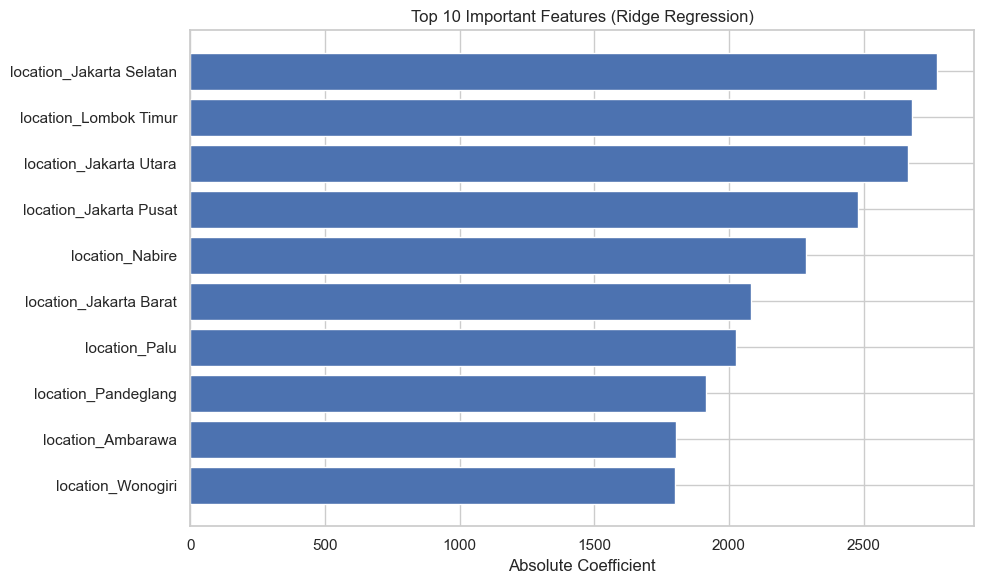

In [66]:
# Get feature names (assuming X_train_final is a DataFrame)
feature_names = X_train_final.columns

# Get coefficients from the trained model
coefficients = best_model.coef_

# Create a DataFrame for better visualization
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Add absolute value for sorting
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])

# Sort by absolute coefficient
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Display top 10 most important features
print(feature_importance.head(10))

# Optional: Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:10][::-1], feature_importance['Abs_Coefficient'][:10][::-1])
plt.xlabel('Absolute Coefficient')
plt.title('Top 10 Important Features (Ridge Regression)')
plt.tight_layout()
plt.show()

## Model 2 - Random Forest Regressor

In [67]:
# Importing Model
from sklearn.ensemble import RandomForestRegressor

In [68]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': [None, 'sqrt'] 
}

from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor(random_state=42)

In [69]:
# Set up GridSearch
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                        # 5-fold cross-validation
    scoring='r2',                # You want the best R²
    n_jobs=-1,                   # Use all processors
    verbose=2
)

# Fit the model
grid_search.fit(X_train_final, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='r2', verbose=2)

In [70]:
print("Best Parameters:", grid_search.best_params_)

# Use the best model
best_rf = grid_search.best_estimator_

Best Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [105]:
# --------- PREDICTION ---------
# On training set
y_train_pred = best_rf.predict(X_train_final)
# On test set
y_test_pred = best_rf.predict(X_test_final)

# ---- Evaluation Metrics ----
def print_metrics(y_true, y_pred, label=""):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    
    print(f"\n--- {label} Performance ---")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

# Print Training Performance
print_metrics(y_train, y_train_pred, label="Training")

# Print Test Performance
print_metrics(y_test, y_test_pred, label="Test")


--- Training Performance ---
MSE : 259039.2100
RMSE: 508.9589
MAE : 308.1073
R²  : 0.9318

--- Test Performance ---
MSE : 988981.7056
RMSE: 994.4756
MAE : 624.4496
R²  : 0.7439


                      Feature  Importance
4               building_area    0.527565
3                   land_area    0.141712
7         building_land_ratio    0.051947
8             area_efficiency    0.037073
63   location_Jakarta Selatan    0.030410
65     location_Jakarta Utara    0.026281
1                    bathroom    0.022969
61     location_Jakarta Barat    0.014919
9                 Total_rooms    0.014356
192                type_rumah    0.013342


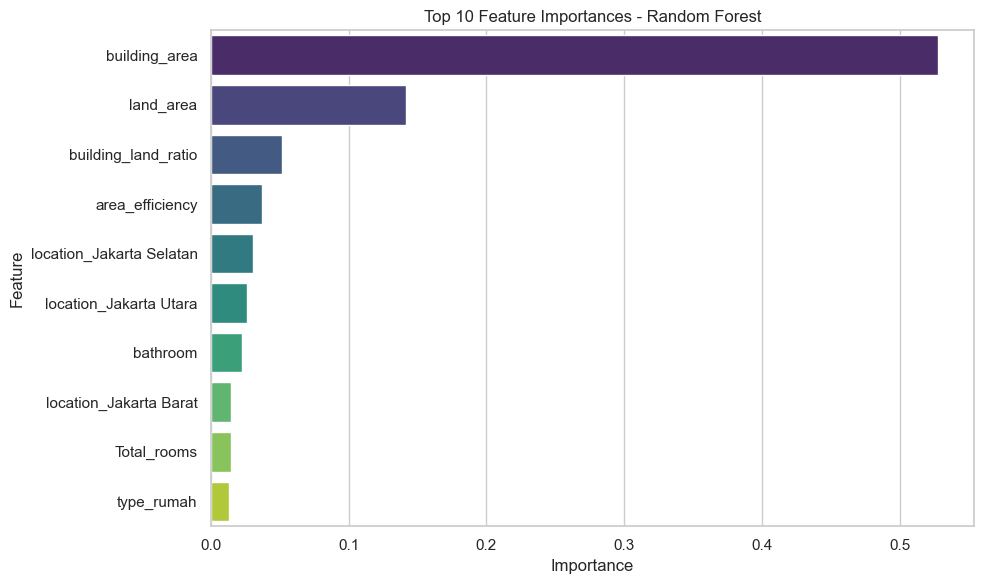

In [72]:
# Create a DataFrame with feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print top features
print(feature_importance.head(10))

# Optional: Visualize
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

## Model 3 - XGBoost

In [73]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [74]:
# Sanitize feature names
X_train_final.columns = X_train_final.columns.astype(str).str.replace('[<>[\]]', '', regex=True)
X_test_final.columns = X_test_final.columns.astype(str).str.replace('[<>[\]]', '', regex=True)


In [75]:
# Define the model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define parameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_lambda': [0, 1, 5],
    'reg_alpha': [0, 1, 5]
}

In [76]:
# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,                  # Number of combinations to try
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [77]:
# Fit
random_search.fit(X_train_final, y_train)

# Best model
best_xgb = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [106]:
# --------- PREDICTION ---------
# On training set
y_train_pred = best_xgb.predict(X_train_final)
# On test set
y_test_pred = best_xgb.predict(X_test_final)

# ---- Evaluation Metrics ----
def print_metrics(y_true, y_pred, label=""):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    
    print(f"\n--- {label} Performance ---")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

# Print Training Performance
print_metrics(y_train, y_train_pred, label="Training")

# Print Test Performance
print_metrics(y_test, y_test_pred, label="Test")


--- Training Performance ---
MSE : 426776.0282
RMSE: 653.2810
MAE : 452.9104
R²  : 0.8877

--- Test Performance ---
MSE : 976292.5358
RMSE: 988.0752
MAE : 644.1267
R²  : 0.7472


                         Feature  Importance
63      location_Jakarta Selatan    0.055293
65        location_Jakarta Utara    0.039072
4                  building_area    0.032067
197          area_category_large    0.024761
30               location_Bekasi    0.019852
61        location_Jakarta Barat    0.018340
62        location_Jakarta Pusat    0.018049
11               location_Badung    0.015698
173           location_Tangerang    0.015632
198  area_category_Uncategorized    0.013354


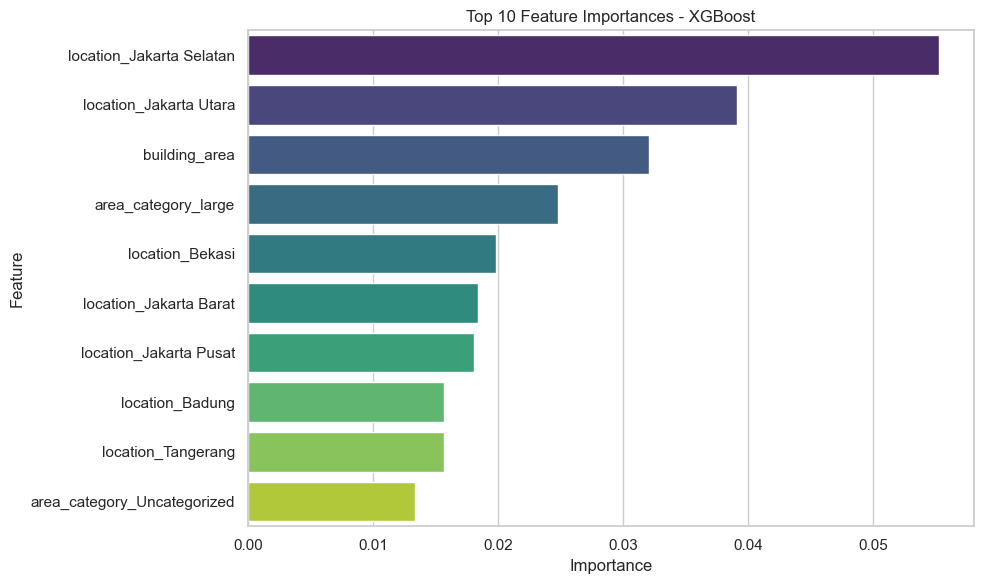

In [117]:
# Create a DataFrame with feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print top features
print(feature_importance.head(10))

# Optional: Visualize
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importances - XGBoost')
plt.tight_layout()
plt.show()

## Model 4 - GradientBoost

In [80]:
from sklearn.ensemble import GradientBoostingRegressor

In [81]:
# Initialize model
gbr = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

In [82]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [83]:
# Randomized Search
random_search_gbr = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=50,
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [84]:
# Fit the model
random_search_gbr.fit(X_train_final, y_train)

# Best model
best_gbr = random_search_gbr.best_estimator_

# Predict
y_pred_gbr_best = best_gbr.predict(X_test_final)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [107]:
# --------- PREDICTION ---------
# On training set
y_train_pred = best_gbr.predict(X_train_final)
# On test set
y_test_pred = best_gbr.predict(X_test_final)

# ---- Evaluation Metrics ----
def print_metrics(y_true, y_pred, label=""):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    
    print(f"\n--- {label} Performance ---")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

# Print Training Performance
print_metrics(y_train, y_train_pred, label="Training")

# Print Test Performance
print_metrics(y_test, y_test_pred, label="Test")


--- Training Performance ---
MSE : 496242.3626
RMSE: 704.4447
MAE : 473.5604
R²  : 0.8694

--- Test Performance ---
MSE : 986003.2495
RMSE: 992.9770
MAE : 652.8826
R²  : 0.7447


                      Feature  Importance
1                    bathroom    0.140286
8             area_efficiency    0.137764
4               building_area    0.135440
3                   land_area    0.113750
197       area_category_large    0.071677
9                 Total_rooms    0.070067
63   location_Jakarta Selatan    0.044049
7         building_land_ratio    0.041496
196      area_category_medium    0.033340
0                     bedroom    0.031822


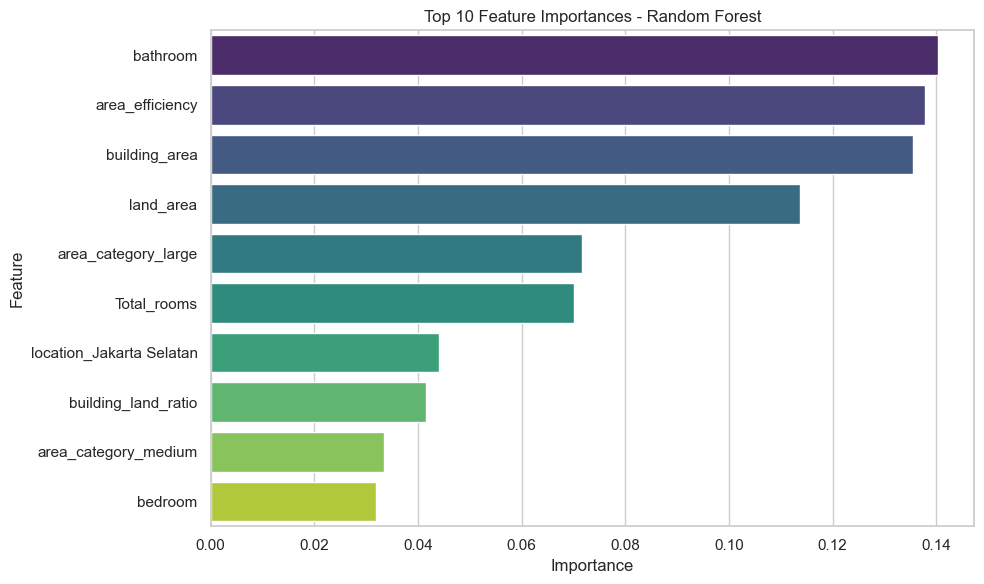

In [86]:
# Create a DataFrame with feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': best_gbr.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print top features
print(feature_importance.head(10))

# Optional: Visualize
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

## Model 5 -

In [87]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [88]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV


In [89]:

param_dist = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [20, 30, 50]
}


In [90]:
lgbm = LGBMRegressor(random_state=42)

# Randomized Search
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=50,
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)



In [91]:
# Fit the model
random_search_lgbm.fit(X_train_final, y_train)

# Best model
best_lgbm = random_search_lgbm.best_estimator_

# Predict
y_pred_lgbm_best = best_lgbm.predict(X_test_final)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 23850, number of used features: 51
[LightGBM] [Info] Start training from score 2459.748118


In [108]:
# --------- PREDICTION ---------
# On training set
y_train_pred = best_lgbm.predict(X_train_final)
# On test set
y_test_pred = best_lgbm.predict(X_test_final)

# ---- Evaluation Metrics ----
def print_metrics(y_true, y_pred, label=""):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    
    print(f"\n--- {label} Performance ---")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

# Print Training Performance
print_metrics(y_train, y_train_pred, label="Training")

# Print Test Performance
print_metrics(y_test, y_test_pred, label="Test")


--- Training Performance ---
MSE : 558107.7634
RMSE: 747.0661
MAE : 494.7890
R²  : 0.8531

--- Test Performance ---
MSE : 985978.0493
RMSE: 992.9643
MAE : 645.6703
R²  : 0.7447


                     Feature  Importance
3                  land_area        8736
8            area_efficiency        5270
4              building_area        5233
7        building_land_ratio        4732
9                Total_rooms        1463
1                   bathroom        1128
0                    bedroom        1103
2                     garage         997
63  location_Jakarta Selatan         507
65    location_Jakarta Utara         497


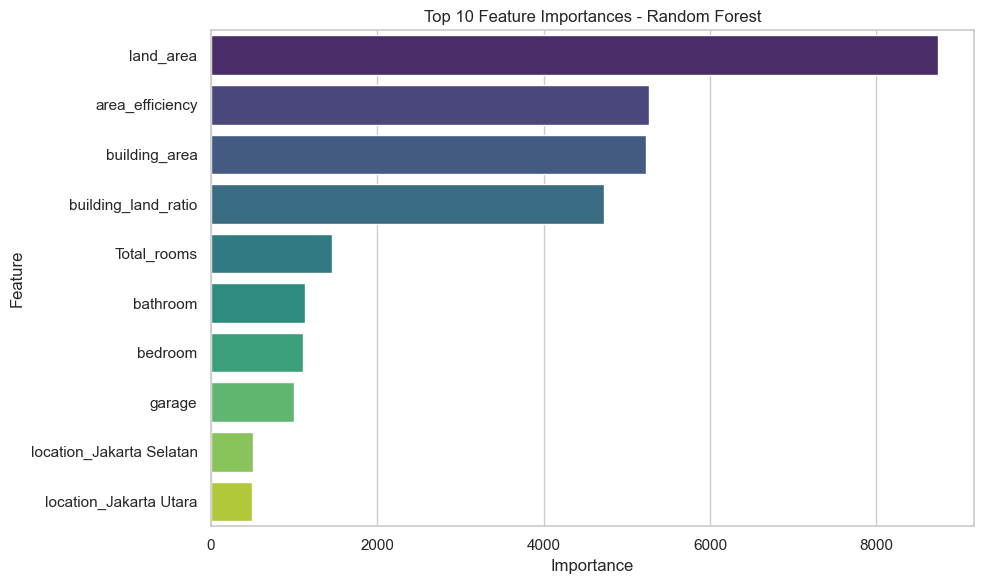

In [93]:
# Create a DataFrame with feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': best_lgbm.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print top features
print(feature_importance.head(10))

# Optional: Visualize
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

# Critical Metric & Evaluation

### Model Performance Comparison

| Model                   | Metric   | Training Performance | Test Performance |
|-------------------------|----------|-----------------------|------------------|
| **Ridge Regression**    | MSE      | 1,264,098.24          | 1,316,144.86     |
|                         | RMSE     | 1,124.32              | 1,147.23         |
|                         | MAE      | 786.86                | 806.47           |
|                         | R²       | 0.6673                | 0.6592           |
| **Random Forest**       | MSE      | 259,039.21            | 988,981.71       |
|                         | RMSE     | 508.96                | 994.48           |
|                         | MAE      | 308.11                | 624.45           |
|                         | R²       | 0.9318                | 0.7439           |
| **XGBoost**             | MSE      | 426,776.03            | 976,292.54       |
|                         | RMSE     | 653.28                | 988.08           |
|                         | MAE      | 452.91                | 644.13           |
|                         | R²       | 0.8877                | 0.7472           |
| **Gradient Boost**      | MSE      | 496,242.36            | 986,003.25       |
|                         | RMSE     | 704.44                | 992.98           |
|                         | MAE      | 473.56                | 652.88           |
|                         | R²       | 0.8694                | 0.7447           |
| **LightGBM**            | MSE      | 558,107.76            | 985,978.05       |
|                         | RMSE     | 747.07                | 992.96           |
|                         | MAE      | 494.79                | 645.67           |
|                         | R²       | 0.8531                | 0.7447           |


### Model Performance Comparison (MAE and R² Only)

| Model                   | Metric | Training Performance | Test Performance |
|-------------------------|--------|-----------------------|------------------|
| **Ridge Regression**    | MAE    | 786.86                | 806.47           |
|                         | R²     | 0.6673                | 0.6592           |
| **Random Forest**       | MAE    | 308.11                | 624.45           |
|                         | R²     | 0.9318                | 0.7439           |
| **XGBoost**             | MAE    | 452.91                | 644.13           |
|                         | R²     | 0.8877                | 0.7472           |
| **Gradient Boost**      | MAE    | 473.56                | 652.88           |
|                         | R²     | 0.8694                | 0.7447           |
| **LightGBM**            | MAE    | 494.79                | 645.67           |
|                         | R²     | 0.8531                | 0.7447           |


Based on the machine learning models we tested, the XGBoost Regression model performed the best, achieving an R² score of 0.7462 and a Mean Absolute Error (MAE) of 644 million rupiah. This indicates that the model can explain 76.6% of the variance in housing prices and, on average, deviates 644 million rupiah from the actual prices. Considering the wide price range in the dataset—from 400 million to 24 billion rupiah—this level of error is within an acceptable margin, especially for high-priced properties where absolute errors naturally tend to be larger. Moreover, XGBoost robustness to outliers and ability to capture non-linear relationships likely contributed to its superior performance compared to other models.

From the model’s feature importance analysis, the most influential predictor is the location, with South Jakarta (5.5%), North Jakarta (3.9%), and other city-specific features dominating the top contributors. The building area, which was previously the strongest predictor, now plays a smaller role with 3.2% importance, suggesting that location has become a more dominant factor in this version of the dataset or model. Additionally, the area size category—particularly the 'large' category (2.5%)—also contributes meaningfully, indicating that both where a property is located and its overall classification (in terms of size) impact pricing decisions more than individual physical dimensions. This shift implies that buyers in the current market may be placing higher value on geographic desirability and broader area context than on raw property size alone.

For another Option, Random Forest could be a viable Alternative, with Lower MAE score means it on average deviates less han XGBoost, however its a little worse at explaining all the variance in the Data.

# Insight & Recommendation

## 🔍 Insights

- **Location-related features** have become the most important drivers of house price prediction in the current model.
  - **South Jakarta** has the highest importance at **5.5%**, followed by **North Jakarta (3.9%)**, and **Bekasi (2.0%)**.
- **Building area**, which was previously the strongest predictor, now contributes only **3.2%**, indicating a **shift in market valuation** toward geographic factors.
- **Area classification**, such as the `large` area category (2.5%), also plays a key role, suggesting that general **property size perception** matters more than exact measurements.
- The importance of features like **Badung**, **Tangerang**, and **Central Jakarta** (each around 1.5–1.8%) shows that **buyer preference is diversifying across regions**.
- The dominance of categorical and location-based features suggests that **macro-level attributes** (location, area category) now outweigh **micro-level dimensions** (e.g., room counts, land/building area).

---

## ✅ Recommendations

### For Real Estate Platforms and Agents

- **Enhance Location-Based Filtering and Search**  
  As location is the most influential factor in pricing, platforms should prioritize **more detailed, accurate, and filterable location metadata**, including **neighborhood, proximity to key landmarks**, and **transport access**.

- **Prominently Display Area Classification Tags**  
  Since area categories (e.g., “large”) influence pricing, include **clear labeling** and allow customers to filter properties by these tags to improve user experience and transparency.

- **Standardize and Enrich Geographic Metadata**  
  Incorporate **urban planning zones, school districts, flood zones, and development plans** into listings to provide additional context for location-driven pricing.

- **Refocus Marketing Around Location Benefits**  
  Highlight lifestyle, convenience, and prestige of each area in listing descriptions, especially for high-interest locations like **Jakarta Selatan** or **Bekasi**.

---

### For Investors and Stakeholders

- **Invest in High-Demand Locations**  
  Allocate capital toward properties in **top-performing regions** like **South Jakarta, North Jakarta, and Bekasi**, as these areas command higher influence in market pricing.

- **Track Urban Expansion and Infrastructure Projects**  
  Monitor government and private developments that improve **accessibility and livability** in underpriced areas to identify **emerging hotspots**.

- **Develop Property Portfolios by Location Cluster**  
  Consider segmenting investments geographically (e.g., central vs suburban) rather than by property type, to align with location-driven market behavior.

- **Position Projects Around Location-Driven Value**  
  Tailor property features and amenities to enhance the **location value proposition**—e.g., co-living near business hubs, green spaces in suburban areas.

---

### For Customers and Home Buyers

- **Prioritize Location Over Size**  
  When evaluating property prices, understand that **where** the property is located often matters **more than its size** in determining value.

- **Use Region-Based Price Comparison Tools**  
  Leverage tools that show **price trends by area**, so you can assess if you're paying a premium or getting a deal based on neighborhood.

- **Consider Long-Term Value of Strategic Areas**  
  Emerging locations like **Bekasi** and **Tangerang** are gaining value and may offer better **long-term return on investment** than saturated areas.

- **Be Mindful of Area Classification Tags**  
  A “large” or “premium” area category may impact both pricing and future resell potential, even if the absolute building size is modest.


# Saving the Model

In [94]:
import joblib

In [95]:
# Save the model
joblib.dump(best_xgb, 'best_xgb_model_house.pkl')

['best_xgb_model_house.pkl']

# Average Utility on Price Range

In [96]:
types = ['rumah', 'gudang', 'villa', 'ruko', 'tanah', 'apartment', 'kavling',
         'house', 'lahan', 'kost', 'apartemen', 'pabrik']

In [97]:
# Define price bins
df_no_outliers['price_bin'] = pd.cut(
    df_no_outliers['Price (In Juta Rupiah)'],
    bins=[0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000, 4000, 6000, np.inf],
    labels=[
        '<250', '250-500', '500-750', '750-1000', '1000-1250', '1250-1500',
        '1500-1750', '1750-2000', '2000-2500', '2500-3000', '3000-4000', '4000-6000', '>6000'
    ]
)

# Dictionary to store summaries
type_price_summaries = {}

# Loop through each building type
for btype in types:
    # Filter DataFrame for the current type
    df_type = df_no_outliers[df_no_outliers['type'].str.lower() == btype.lower()]
    
    if not df_type.empty:
        # Group by price bin and calculate the mean of selected features
        summary = df_type.groupby('price_bin')[['bedroom', 'bathroom', 'garage', 'land_area', 'building_area']]\
                         .mean().round(1)
        type_price_summaries[btype] = summary




In [98]:
# Example: Access the summary for 'rumah'
type_price_summaries['rumah']

bedroom  bathroom  garage  land_area  building_area
price_bin                                                     
<250           1.7       1.1     0.7       92.3           49.4
250-500        1.9       1.2     0.6       74.0           51.6
500-750        2.2       1.4     0.6       81.7           62.9
750-1000       2.6       1.7     0.7       91.5           81.2
1000-1250      2.8       2.0     0.8       98.3           93.5
1250-1500      3.0       2.2     0.9      106.2          110.6
1500-1750      3.1       2.4     1.0      114.9          122.8
1750-2000      3.3       2.5     1.0      125.4          133.6
2000-2500      3.4       2.6     1.1      135.3          148.6
2500-3000      3.5       2.9     1.2      151.4          173.2
3000-4000      3.7       3.1     1.3      178.3          199.5
4000-6000      3.9       3.3     1.4      215.0          243.4
>6000          4.1       3.5     1.5      272.6          293.4

In [99]:
# Overall count of items in each price bin
bin_counts_overall = df_no_outliers['price_bin'].value_counts().sort_index()
print(bin_counts_overall)


price_bin
<250          691
250-500      2127
500-750      2602
750-1000     2924
1000-1250    1787
1250-1500    2245
1500-1750    1712
1750-2000    1985
2000-2500    2647
2500-3000    2405
3000-4000    3141
4000-6000    3527
>6000        2020
Name: count, dtype: int64


In [100]:
df_no_outliers['price_bin'] = pd.cut(
    df_no_outliers['Price (In Juta Rupiah)'],
    bins=[0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000, 4000, 6000, np.inf],
    labels=['<250', '250-500', '500-750', '750-1000', '1000-1250', '1250-1500',
            '1500-1750', '1750-2000', '2000-2500', '2500-3000', '3000-4000', '4000-6000', '>6000']
)


In [101]:
types = df_no_outliers['type'].unique()
locations = df_no_outliers['location'].unique()

type_price_summaries = {}

for location in locations:
    for btype in types:
        df_filtered = df_no_outliers[
            (df_no_outliers['location'].str.lower() == location.lower()) &
            (df_no_outliers['type'].str.lower() == btype.lower())
        ]
        if not df_filtered.empty:
            summary = df_filtered.groupby('price_bin')[['bedroom', 'bathroom', 'garage', 'land_area', 'building_area']]\
                                 .mean().round(1)
            type_price_summaries[(location, btype)] = summary


In [102]:
type_price_summaries[('Jakarta Selatan', 'rumah')]


bedroom  bathroom  garage  land_area  building_area
price_bin                                                     
<250           1.9       1.7     0.9      162.0          131.4
250-500        1.3       1.2     0.0       25.5           37.1
500-750        1.8       1.4     0.8       46.9           50.6
750-1000       2.4       1.7     0.6       60.3           73.0
1000-1250      2.1       1.6     0.6       51.4           66.9
1250-1500      2.7       2.4     0.9       74.0           99.9
1500-1750      2.9       2.3     0.9       90.7          110.5
1750-2000      3.0       2.5     1.0       88.4          118.9
2000-2500      3.3       2.7     1.0       99.7          136.7
2500-3000      3.4       2.7     1.1      128.9          157.3
3000-4000      3.5       2.8     1.2      143.3          181.2
4000-6000      3.7       3.1     1.4      192.6          227.3
>6000          3.8       3.1     1.5      254.8          266.5

In [103]:
import pickle

with open("type_price_summaries.pkl", "wb") as f:
    pickle.dump(type_price_summaries, f)
